In [ ]:
# ============================================================================
# CELL 1: Setup and Mount Drive
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")


Mounted at /content/drive
✓ Google Drive mounted successfully


In [ ]:
!git clone https://github.com/dxli94/WLASL.git

Cloning into 'WLASL'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 237 (delta 60), reused 49 (delta 49), pack-reused 147 (from 4)
Receiving objects: 100% (237/237), 3.74 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
!pip -q install yt-dlp tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.0 MB/s eta 0:00:00


In [ ]:
import json, re, itertools
from pathlib import Path

ann_path = Path("WLASL") / "start_kit" / "WLASL_v0.3.json"  # try v1.1 (common); if missing, check repo for latest
with open(ann_path, "r") as f:
    WLASL = json.load(f)

want = ["HELLO","THANK YOU","PLEASE","YES","NO","HELP","STOP","SORRY","GOOD","BAD"]
norm = lambda s: re.sub(r"[^A-Z0-9]", "", s.upper())

# find candidate glosses for each target
candidates = {}
all_glosses = sorted({e["gloss"] for e in WLASL})
for w in want:
    wnorm = norm(w)
    hits = [g for g in all_glosses if norm(g)==wnorm or w in g or w.replace(" ","_") in g or w.replace(" ","-") in g]
    if not hits:
        # fallback: fuzzy contains ignoring - and _
        hits = [g for g in all_glosses if norm(g)==wnorm or norm(w) in norm(g)]
    candidates[w] = hits[:10]

candidates  # review this dict and pick one gloss per word

{'HELLO': ['hello'],
 'THANK YOU': ['thank you'],
 'PLEASE': ['please'],
 'YES': ['yes'],
 'NO': ['no'],
 'HELP': ['help'],
 'STOP': ['stop'],
 'SORRY': ['sorry'],
 'GOOD': ['good'],
 'BAD': ['bad']}

Cell 1 - Discover classes & counts (from your downloaded clips)

In [ ]:
import os, math, subprocess, shlex, random
from pathlib import Path
from tqdm import tqdm

DATA_ROOT = Path("/content/data/word_videos")
TMP = Path("/content/tmp_wlasl_raw")
for p in [DATA_ROOT, TMP]:
    p.mkdir(parents=True, exist_ok=True)

N_PER_CLASS = 40    # adjust as needed
random.seed(1234)

def pick_samples_for_gloss(gloss, n):
    pool = [s for s in samples if s["gloss"] == gloss]
    random.shuffle(pool)
    return pool[:n]

def get_url(s):
    # Prefer explicit URL; else fall back to YouTube ID if present
    if "url" in s and s["url"]:
        return s["url"]
    vid = s.get("video_id") or s.get("video")
    return f"https://www.youtube.com/watch?v={vid}" if vid else None

def to_seconds(frame_idx, fps):
    return max(0.0, (frame_idx - 1) / (fps or 25))

def run(cmd_list):
    # Set text=False to prevent decoding errors
    return subprocess.run(cmd_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=False)

for g in CLASS_LIST:
    items = pick_samples_for_gloss(g, N_PER_CLASS)
    outdir = DATA_ROOT / g
    outdir.mkdir(parents=True, exist_ok=True)
    for s in tqdm(items, desc=f"Downloading {g}"):
        url = get_url(s)
        if not url:
            continue
        fps = s.get("fps", 25)
        fs, fe = int(s.get("frame_start", 1)), int(s.get("frame_end", -1))
        if fe == -1: fe = fs + 75  # ~3s fallback
        ss, ee = to_seconds(fs, fps), to_seconds(fe, fps)
        dur = max(0.2, ee - ss)
        vid = s.get("video_id") or s.get("id") or f"seg_{fs}_{fe}"
        raw = TMP / f"{vid}.mp4"
        if not raw.exists():
            # Use list for yt-dlp command
            yt_dlp_cmd = ['yt-dlp', '-f', 'mp4', '-o', str(raw), url]
            _ = run(yt_dlp_cmd)
        if not raw.exists():
            # link might be dead; skip
            continue
        out = outdir / f"{g}_{vid}_{fs}_{fe}.mp4"
        # Use list for ffmpeg command
        ffmpeg_cmd = [
            'ffmpeg', '-y', '-ss', f'{ss:.3f}', '-i', str(raw), '-t', f'{dur:.3f}',
            '-an', '-c:v', 'libx264', '-preset', 'veryfast', '-crf', '23', str(out)
        ]
        _ = run(ffmpeg_cmd)

In [ ]:
import os, json, math, subprocess, shlex, random
from pathlib import Path
from tqdm import tqdm

DATA_ROOT = Path("/content/data/word_videos")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
N_PER_CLASS = 40            # try 20–40 per word to start
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)

# >>> Replace with the exact glosses you chose from the candidates above <<<
CLASS_LIST = ["HELLO","THANK-YOU","PLEASE","YES","NO","HELP","STOP","SORRY","GOOD","BAD"]

with open(ann_path, "r") as f:
    WLASL = json.load(f)

# group instances by gloss
by_gloss = {g: [] for g in CLASS_LIST}
for entry in WLASL:
    g = entry["gloss"]
    if g in by_gloss:
        for inst in entry["instances"]:
            # Some JSON versions use "video_id" (YouTube ID); build URL
            vid = inst.get("video_id") or inst.get("video", "")
            if not vid:
                continue
            url = f"https://www.youtube.com/watch?v={vid}"
            fps = entry.get("fps", 25)  # WLASL states decoding at 25 fps
            fs, fe = inst["frame_start"], inst["frame_end"]
            if fe == -1:
                fe = fs + 75  # fallback: ~3s segment if end is -1
            start_s, end_s = (fs-1)/fps, (fe-1)/fps
            by_gloss[g].append({
                "url": url, "start": start_s, "end": end_s, "signer": inst.get("signer_id", -1),
                "id": f'{vid}_{fs}_{fe}'
            })

# shuffle and cut down to N_PER_CLASS each
for g in CLASS_LIST:
    random.shuffle(by_gloss[g])
    by_gloss[g] = by_gloss[g][:N_PER_CLASS]

# download + trim
def run(cmd):
    return subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

TMP = Path("/content/tmp_wlasl_raw"); TMP.mkdir(exist_ok=True, parents=True)

for g in CLASS_LIST:
    outdir = DATA_ROOT / g
    outdir.mkdir(parents=True, exist_ok=True)
    for item in tqdm(by_gloss[g], desc=f"Downloading {g}"):
        url, start, end, vid = item["url"], item["start"], item["end"], item["id"]
        raw = TMP / f"{vid}.mp4"
        if not raw.exists():
            r = run(f'yt-dlp -f mp4 -o "{raw}" {url}')
        if not raw.exists():
            # skip if YouTube unavailable
            continue
        # trim (re-encode for reliable cuts)
        out = outdir / f"{g}_{vid}.mp4"
        dur = max(0.2, end - start)
        cmd = f'ffmpeg -y -ss {start:.3f} -i "{raw}" -t {dur:.3f} -an -c:v libx264 -preset veryfast -crf 23 "{out}"'
        run(cmd)


Cell 2 — Build stratified splits (train/val/test) and preprocess to NPY

In [ ]:
from pathlib import Path
import json, glob, itertools

# 1) Auto-pick the WLASL annotation JSON
# candidates = sorted(glob.glob("WLASL/WLASL_v*.json"))
# assert candidates, "No WLASL_v*.json found in ./WLASL — did you clone the repo?"
ann_path = Path("WLASL") / "start_kit" / "WLASL_v0.3.json"  # Use the known correct path
# ann_path = candidates[-1]  # pick the newest version
print("Using annotation file:", ann_path)

# 2) Load + normalize to a uniform "samples list"
raw = json.load(open(ann_path, "r"))

# Support both possible formats:
# A) [{"gloss": "HELLO", "instances":[{...}, ...]}, ...]
# B) [{"gloss": "HELLO", "url": "...", "frame_start": ..., ...}, ...]
samples = []
if raw and isinstance(raw[0], dict) and "instances" in raw[0]:
    for entry in raw:
        g = entry["gloss"]
        for inst in entry["instances"]:
            s = {"gloss": g}
            s.update(inst)
            samples.append(s)
else:
    samples = raw

print(f"Total samples parsed: {len(samples)}")
print("Example keys of one sample:", sorted(samples[0].keys()))
# Summarize how many samples per gloss (top 20)
from collections import Counter
cnt = Counter([s["gloss"] for s in samples])
print("Top glosses by count:", cnt.most_common(20)[:10])

Using annotation file: WLASL/start_kit/WLASL_v0.3.json
Total samples parsed: 21083
Example keys of one sample: ['bbox', 'fps', 'frame_end', 'frame_start', 'gloss', 'instance_id', 'signer_id', 'source', 'split', 'url', 'variation_id', 'video_id']
Top glosses by count: [('book', 40), ('drink', 35), ('computer', 30), ('before', 26), ('chair', 26), ('go', 26), ('clothes', 25), ('who', 25), ('candy', 24), ('cousin', 23)]


In [ ]:
from pathlib import Path
import glob, os
from collections import Counter

DATA_ROOT = Path("/content/data/word_videos")  # ← adjust if different
assert DATA_ROOT.exists(), f"Folder not found: {DATA_ROOT}"

# Auto-discover class names from subfolders, excluding hidden directories
WORDS = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir() and not p.name.startswith('.')])
print("Discovered classes:", WORDS)

# Count videos per class
counts = {w: len(glob.glob(str(DATA_ROOT / w / "*.*"))) for w in WORDS}
print("Per-class counts:", counts)


import numpy as np, json
from collections import Counter

NPY_OUT = "/content/data/word_splits"
X_train = np.load(f"{NPY_OUT}/X_train.npy", mmap_mode='r')
y_train = np.load(f"{NPY_OUT}/y_train.npy", mmap_mode='r')
X_val   = np.load(f"{NPY_OUT}/X_val.npy",   mmap_mode='r')
y_val   = np.load(f"{NPY_OUT}/y_val.npy",   mmap_mode='r')
X_test  = np.load(f"{NPY_OUT}/X_test.npy",  mmap_mode='r')
y_test  = np.load(f"{NPY_OUT}/y_test.npy",  mmap_mode='r')
WORDS = json.load(open(f"{NPY_OUT}/labels.json"))

def pretty_counts(name, y):
    c = Counter(y.tolist())
    print(name, {WORDS[k]: c[k] for k in sorted(c)})

pretty_counts("train", y_train)
pretty_counts("val",   y_val)
pretty_counts("test",  y_test)
print("sizes:", len(y_train), len(y_val), len(y_test))


Discovered classes: ['bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank you', 'yes']
Per-class counts: {'bad': 11, 'good': 11, 'hello': 7, 'help': 11, 'no': 15, 'please': 9, 'sorry': 9, 'stop': 6, 'thank you': 7, 'yes': 16}
train {'bad': 7, 'good': 7, 'hello': 5, 'help': 7, 'no': 11, 'please': 7, 'sorry': 7, 'stop': 4, 'thank you': 5, 'yes': 12}
val {'bad': 2, 'good': 2, 'hello': 1, 'help': 2, 'no': 2, 'please': 1, 'sorry': 1, 'stop': 1, 'thank you': 1, 'yes': 2}
test {'bad': 2, 'good': 2, 'hello': 1, 'help': 2, 'no': 2, 'please': 1, 'sorry': 1, 'stop': 1, 'thank you': 1, 'yes': 2}
sizes: 72 15 15


In [ ]:
import re
from collections import defaultdict, Counter

want = ["HELLO","THANK YOU","PLEASE","YES","NO","HELP","STOP","SORRY","GOOD","BAD"]
def norm(s): return re.sub(r"[^A-Z0-9]", "", s.upper())

all_glosses = sorted(set(s["gloss"] for s in samples))
by_gloss = defaultdict(list)
for s in samples:
    by_gloss[s["gloss"]].append(s)

mapping = {}
for w in want:
    wn = norm(w)
    # exact normalized, then fuzzy contains
    cands = [g for g in all_glosses if norm(g) == wn] or \
            [g for g in all_glosses if wn in norm(g)]
    # rank by number of instances
    cands = sorted(cands, key=lambda g: len(by_gloss[g]), reverse=True)
    mapping[w] = cands[:5]

print("Candidates per target (top 5 by count):")
for w, c in mapping.items():
    print(f"{w:>10} -> {c[:5]} (counts: {[len(by_gloss[g]) for g in c[:5]]})")

# >>> PICK the first option for each word unless you have a better choice
CLASS_LIST = []
for w in want:
    chosen = mapping[w][0] if mapping[w] else None
    if not chosen:
        print("No gloss candidates for:", w)
    else:
        CLASS_LIST.append(chosen)

print("\nChosen CLASS_LIST =", CLASS_LIST)
print({g: len(by_gloss[g]) for g in CLASS_LIST})


Candidates per target (top 5 by count):
     HELLO -> ['hello'] (counts: [13])
 THANK YOU -> ['thank you'] (counts: [14])
    PLEASE -> ['please'] (counts: [15])
       YES -> ['yes'] (counts: [22])
        NO -> ['no'] (counts: [22])
      HELP -> ['help'] (counts: [22])
      STOP -> ['stop'] (counts: [11])
     SORRY -> ['sorry'] (counts: [14])
      GOOD -> ['good'] (counts: [16])
       BAD -> ['bad'] (counts: [16])

Chosen CLASS_LIST = ['hello', 'thank you', 'please', 'yes', 'no', 'help', 'stop', 'sorry', 'good', 'bad']
{'hello': 13, 'thank you': 14, 'please': 15, 'yes': 22, 'no': 22, 'help': 22, 'stop': 11, 'sorry': 14, 'good': 16, 'bad': 16}


In [ ]:
import numpy as np, cv2, json, math, random, glob, os
from pathlib import Path
from collections import defaultdict

random.seed(1234)
np.random.seed(1234)

NPY_OUT = Path("/content/data/word_splits")
NPY_OUT.mkdir(parents=True, exist_ok=True)

IMAGE_SIZE = (128,128)   # training resolution
T = 24                   # frames per clip (uniform sampling)
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

def list_videos_folder(root, words):
    items = []
    for w in words:
        for p in glob.glob(str(Path(root)/w/"*.*")):
            if p.lower().endswith((".mp4",".mov",".avi",".mkv",".webm")):
                items.append((p, w))
    return items

def split_items(items, val_ratio=0.15, test_ratio=0.15, seed=1234):
    by_label = defaultdict(list)
    for p, w in items:
        by_label[w].append(p)
    rng = np.random.default_rng(seed)
    train, val, test = [], [], []
    for w, paths in by_label.items():
        rng.shuffle(paths)
        n = len(paths)
        nv = max(1, int(round(n*val_ratio))) if n>=6 else max(1, int(n*0.2))
        nt = max(1, int(round(n*test_ratio))) if n>=6 else max(1, int(n*0.2))
        # Cap so we don't exceed n
        nv = min(nv, max(1, n//4))
        nt = min(nt, max(1, (n-nv)//4)) if n-nv>=2 else 1
        val.extend([(p,w) for p in paths[:nv]])
        test.extend([(p,w) for p in paths[nv:nv+nt]])
        train.extend([(p,w) for p in paths[nv+nt:]])
    return train, val, test

def read_video_uniform(path, T=24, target_hw=(128,128)):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {path}")
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(frames-1,0), T).astype(int) if frames>0 else np.zeros(T, dtype=int)

    imgs = np.empty((T, target_hw[0], target_hw[1], 3), dtype=np.float32)
    filled = np.zeros((T,), dtype=bool)
    f_idx = 0
    ok, frame = cap.read()
    while ok:
        if f_idx in idxs:
            h,w = frame.shape[:2]
            m = min(h,w); y0=(h-m)//2; x0=(w-m)//2
            crop = frame[y0:y0+m, x0:x0+m]
            crop = cv2.resize(crop, target_hw, interpolation=cv2.INTER_AREA)
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            pos = np.where(idxs==f_idx)[0][0]
            imgs[pos] = rgb.astype(np.float32)/255.0
            filled[pos] = True
        ok, frame = cap.read(); f_idx += 1
    cap.release()
    # Fill any gaps by nearest filled frame
    for i in range(T):
        if not filled[i]:
            left = max([j for j in range(i,-1,-1) if filled[j]], default=None)
            right = min([j for j in range(i,T) if filled[j]], default=None)
            pick = left if right is None else (right if left is None else (left if (i-left) <= (right-i) else right))
            imgs[i] = imgs[pick] if pick is not None else np.zeros_like(imgs[i])
    return imgs

def preprocess_save(items, split_name, words, out_dir=NPY_OUT, T=24, image_size=(128,128)):
    lbl2id = {w:i for i,w in enumerate(words)}
    X_list, y_list = [], []
    for p, w in items:
        try:
            arr = read_video_uniform(p, T=T, target_hw=image_size)
            X_list.append(arr); y_list.append(lbl2id[w])
        except Exception as e:
            print("ERROR reading", p, ":", e)
    X = np.stack(X_list).astype(np.float32) if X_list else np.zeros((0,T,image_size[0],image_size[1],3), np.float32)
    y = np.array(y_list, dtype=np.int32)
    np.save(out_dir / f"X_{split_name}.npy", X)
    np.save(out_dir / f"y_{split_name}.npy", y)
    print(split_name, "→", X.shape, y.shape)

items = list_videos_folder(DATA_ROOT, WORDS)
train_items, val_items, test_items = split_items(items, VAL_SPLIT, TEST_SPLIT, seed=1234)
print(f"split sizes: train={len(train_items)}, val={len(val_items)}, test={len(test_items)}")

preprocess_save(train_items, "train", WORDS, T=T, image_size=IMAGE_SIZE)
preprocess_save(val_items,   "val",   WORDS, T=T, image_size=IMAGE_SIZE)
preprocess_save(test_items,  "test",  WORDS, T=T, image_size=IMAGE_SIZE)

# Save labels for later integration
with open(NPY_OUT / "labels.json", "w") as f:
    json.dump(WORDS, f, indent=2)
print("Saved labels.json:", WORDS)


split sizes: train=72, val=15, test=15
train → (72, 24, 128, 128, 3) (72,)
val → (15, 24, 128, 128, 3) (15,)
test → (15, 24, 128, 128, 3) (15,)
Saved labels.json: ['bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank you', 'yes']


Cell 3 — Load NPY (memmap) and build tf.data

In [ ]:
import numpy as np, tensorflow as tf, os
from pathlib import Path

AUTOTUNE = tf.data.AUTOTUNE
NPY_OUT = Path("/content/data/word_splits")

# Load the full memory-mapped arrays
X_train = np.load(NPY_OUT/"X_train.npy", mmap_mode='r')
y_train = np.load(NPY_OUT/"y_train.npy", mmap_mode='r')
X_val   = np.load(NPY_OUT/"X_val.npy",   mmap_mode='r')
y_val   = np.load(NPY_OUT/"y_val.npy",   mmap_mode='r')
X_test  = np.load(NPY_OUT/"X_test.npy",  mmap_mode='r')
y_test  = np.load(NPY_OUT/"y_test.npy",  mmap_mode='r')

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

# Define T, H, and W based on the loaded data shape
# Assuming X_train has shape (num_samples, T, H, W, channels)
if X_train.shape:
    _, T, H, W, _ = X_train.shape
else:
    # Fallback if X_train is empty, though this shouldn't happen with data
    T, H, W = 24, 128, 128 # Default values

def make_seq_ds(X, y, training=True, batch=8, seed=1234):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(len(y), seed=seed) # Shuffle the zipped dataset
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds


train_ds = make_seq_ds(X_train, y_train, training=True,  batch=8)
val_ds   = make_seq_ds(X_val,   y_val,   training=False, batch=8)
test_ds  = make_seq_ds(X_test,  y_test,  training=False, batch=8)

# NUM_CLASSES is correctly calculated from y_train
NUM_CLASSES = int(np.max(y_train)) + 1

Train: (72, 24, 128, 128, 3) (72,)
Val:   (15, 24, 128, 128, 3) (15,)
Test:  (15, 24, 128, 128, 3) (15,)


Cell 4 — Tiny overfit sanity test (must climb)

In [ ]:
# === Cell 4 (patched) — Pretrained MobileNetV2 + Temporal Average with memmap-safe loader ===
import tensorflow as tf, numpy as np, os, json
from tensorflow.keras import layers, models

# --- compat loss: sparse CE + label smoothing (since SparseCCE(..., label_smoothing=...) is unsupported in your TF) ---
def sparse_cce_with_ls(num_classes, epsilon=0.05):
    base = tf.keras.losses.CategoricalCrossentropy()
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes, dtype=y_pred.dtype)
        if epsilon and epsilon > 0:
            y_true_oh = y_true_oh * (1.0 - epsilon) + (epsilon / tf.cast(num_classes, y_pred.dtype))
        return base(y_true_oh, y_pred)
    return loss_fn

# Load splits (safe to re-run)
NPY_OUT = "/content/data/word_splits"
X_train = np.load(os.path.join(NPY_OUT,"X_train.npy"), mmap_mode='r')
y_train = np.load(os.path.join(NPY_OUT,"y_train.npy"), mmap_mode='r')
X_val   = np.load(os.path.join(NPY_OUT,"X_val.npy"),   mmap_mode='r')
y_val   = np.load(os.path.join(NPY_OUT,"y_val.npy"),   mmap_mode='r')

NUM_CLASSES = int(np.max(y_train)) + 1
T, H, W = X_train.shape[1:4]

# ---- memmap-safe tf.data loader (uses tf.numpy_function) ----
AUTOTUNE = tf.data.AUTOTUNE

def make_seq_ds_np(X, y, training=True, batch=4, seed=1234):
    N = len(y)
    idx = tf.data.Dataset.from_tensor_slices(tf.range(N, dtype=tf.int64))
    if training:
        idx = idx.shuffle(min(1024, N), seed=seed, reshuffle_each_iteration=True)

    # small NumPy helpers for numpy_function
    def _get_x(i_np): return X[int(i_np)]
    def _get_y(i_np): return y[int(i_np)]

    def _loader(i):
        xi = tf.numpy_function(_get_x, [i], tf.float32)  # pulls (T,H,W,C) from memmap
        yi = tf.numpy_function(_get_y, [i], tf.int32)    # scalar label
        # set static shapes so Keras can build the model
        xi.set_shape((T, H, W, 3))
        yi.set_shape(())
        return xi, yi

    ds = idx.map(_loader, num_parallel_calls=AUTOTUNE)
    return ds.batch(batch).prefetch(AUTOTUNE)

train_ds = make_seq_ds_np(X_train, y_train, training=True,  batch=4)
val_ds   = make_seq_ds_np(X_val,   y_val,   training=False, batch=4)

# ---- Pretrained MobileNetV2 frame encoder (expects [-1,1]) ----
def frame_mnet(input_hw=(128,128), emb_dim=128, alpha=0.5, trainable_backbone=False):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(input_hw[0], input_hw[1], 3),
        include_top=False, weights="imagenet", alpha=alpha
    )
    base.trainable = trainable_backbone
    x = layers.Input(shape=(input_hw[0], input_hw[1], 3))
    z = layers.Rescaling(scale=2.0, offset=-1.0)(x)   # [0,1] -> [-1,1]
    z = base(z, training=False)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(emb_dim, activation='relu')(z)
    return models.Model(x, z, name="frame_mnetv2")

def seq_model_tavg(T, hw=(128,128), num_classes=10, emb_dim=128, alpha=0.5):
    frames = layers.Input(shape=(T, hw[0], hw[1], 3))
    cnn = frame_mnet(hw, emb_dim, alpha=alpha, trainable_backbone=False)
    feats = layers.TimeDistributed(cnn)(frames)   # (B,T,emb_dim)
    x = layers.GlobalAveragePooling1D()(feats)    # temporal average
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(frames, out, name="mnet_tavg")

model = seq_model_tavg(T=T, hw=(H,W), num_classes=NUM_CLASSES, emb_dim=128, alpha=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
              loss=sparse_cce_with_ls(NUM_CLASSES, 0.05),
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')])
model.summary()

ckpt_dir = "/content/speakez_word_artifacts"; os.makedirs(ckpt_dir, exist_ok=True)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, "best_word_mnet_tavg.h5"),
    monitor="val_accuracy", save_best_only=True, verbose=1
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ckpt
]

# No class_weight for now (tiny data)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks, verbose=2)


Model: "mnet_tavg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 24, 128)        │       870,192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,482 (3.32 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 706,224 (2.69 MB)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.06667, saving model to /content/speakez_word_artifacts/best_word_mnet_tavg.h5


18/18 - 171s - 9s/step - accuracy: 0.1250 - loss: 2.6611 - top3_acc: 0.3750 - val_accuracy: 0.0667 - val_loss: 2.4248 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy improved from 0.06667 to 0.20000, saving model to /content/speakez_word_artifacts/best_word_mnet_tavg.h5


18/18 - 18s - 985ms/step - accuracy: 0.2222 - loss: 2.0481 - top3_acc: 0.6250 - val_accuracy: 0.2000 - val_loss: 2.3057 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.20000
18/18 - 15s - 816ms/step - accuracy: 0.3333 - loss: 1.7847 - top3_acc: 0.6389 - val_accuracy: 0.0667 - val_loss: 2.3277 - val_top3_acc: 0.4667 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.20000
18/18 - 20s - 1s/step - accuracy: 0.4722 - loss: 1.5343 - top3_acc: 0.8472 - val_accuracy: 0.1333 - val_loss: 2.6767 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.20000
18/18 - 14s - 800ms/step - accuracy: 0.5556 - loss: 1.3494 - top3_acc: 0.8611 - val_accuracy: 0.1333 - val_loss: 2.7731 - val_top3_acc: 0.3333 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: val_accuracy did not improve fro

Cell 6 — Train full CNN→BiLSTM (with callbacks)

In [ ]:
# === Cell 5 (fixed) — Train full CNN→BiLSTM with compat label smoothing ===
import os, json, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# --- compat loss: sparse CE with label smoothing via one-hot ---
def sparse_cce_with_ls(num_classes, epsilon=0.05):
    base = tf.keras.losses.CategoricalCrossentropy()  # no smoothing arg here
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes, dtype=y_pred.dtype)
        if epsilon and epsilon > 0:
            y_true_oh = y_true_oh * (1.0 - epsilon) + (epsilon / tf.cast(num_classes, y_pred.dtype))
        return base(y_true_oh, y_pred)
    return loss_fn

# --- frame CNN reused per frame ---
def frame_cnn(input_hw=(128,128), emb_dim=128):
    inputs = layers.Input(shape=(input_hw[0], input_hw[1], 3))
    x = inputs
    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(emb_dim, activation='relu')(x)
    return models.Model(inputs, x, name="frame_cnn")

def seq_model_bilstm(T, hw=(128,128), num_classes=10, emb_dim=128, lstm_dim=128):
    frames = layers.Input(shape=(T, hw[0], hw[1], 3))
    cnn = frame_cnn(hw, emb_dim)
    feats = layers.TimeDistributed(cnn)(frames)             # (B,T,emb_dim)
    x = layers.Bidirectional(layers.LSTM(lstm_dim, return_sequences=True))(feats)
    x = layers.Bidirectional(layers.LSTM(lstm_dim))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(frames, out, name="cnn_bilstm")

# Expect NUM_CLASSES, T, H, W, train_ds, val_ds already defined in previous cells
model = seq_model_bilstm(T=T, hw=(H,W), num_classes=NUM_CLASSES, emb_dim=128, lstm_dim=128)

metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')]
loss = sparse_cce_with_ls(num_classes=NUM_CLASSES, epsilon=0.05)
opt  = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()

ckpt_dir = "/content/speakez_word_artifacts"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, "best_word_cnn_bilstm.h5"),
    monitor="val_accuracy", save_best_only=True, verbose=1
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ckpt
]

# Optional: class weights (cap extremes to avoid instability)
unique, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
raw_w = {int(k): float(total / (len(unique) * v)) for k, v in zip(unique, counts)}
med = float(np.median(list(raw_w.values())))
class_weight = {k: min(v, 3.0*med) for k, v in raw_w.items()}
print("class_weight (first 5):", list(class_weight.items())[:5], "...")

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight,   # remove this arg if training destabilizes
    verbose=2
)

# Save history for your report
with open(os.path.join(ckpt_dir, "history_word.json"), "w") as f:
    json.dump(history.history, f)
print("Saved:", os.path.join(ckpt_dir, "history_word.json"))


Model: "cnn_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 24, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 24, 128)        │       110,656 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,634 (2.94 MB)

 Trainable params: 770,186 (2.94 MB)

 Non-trainable params: 448 (1.75 KB)

class_weight (first 5): [(0, 1.0285714285714285), (1, 1.0285714285714285), (2, 1.44), (3, 1.0285714285714285), (4, 0.6545454545454545)] ...
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.13333, saving model to /content/speakez_word_artifacts/best_word_cnn_bilstm.h5


18/18 - 132s - 7s/step - accuracy: 0.1944 - loss: 2.5130 - top3_acc: 0.3611 - val_accuracy: 0.1333 - val_loss: 2.4339 - val_top3_acc: 0.2667 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy improved from 0.13333 to 0.20000, saving model to /content/speakez_word_artifacts/best_word_cnn_bilstm.h5


18/18 - 88s - 5s/step - accuracy: 0.0417 - loss: 2.4432 - top3_acc: 0.3056 - val_accuracy: 0.2000 - val_loss: 2.3647 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.20000
18/18 - 92s - 5s/step - accuracy: 0.1667 - loss: 2.3684 - top3_acc: 0.4028 - val_accuracy: 0.1333 - val_loss: 2.3971 - val_top3_acc: 0.3333 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.20000
18/18 - 88s - 5s/step - accuracy: 0.1806 - loss: 2.2814 - top3_acc: 0.4306 - val_accuracy: 0.1333 - val_loss: 2.3662 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.20000
18/18 - 93s - 5s/step - accuracy: 0.1667 - loss: 2.2943 - top3_acc: 0.4306 - val_accuracy: 0.0667 - val_loss: 2.3271 - val_top3_acc: 0.4000 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.20000
18/18 - 88s - 5s/step - accuracy: 0.1250 - loss: 2.2734 - top3_acc: 0.4167 -

X_train global mean/std: 0.4203979969024658 0.35339003801345825
Fraction near-black sequences (mean<0.01): 0.0


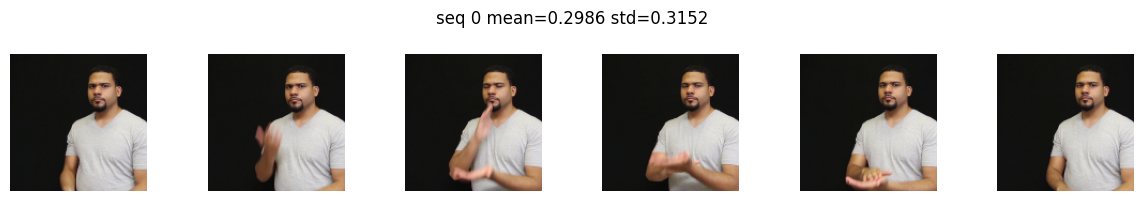

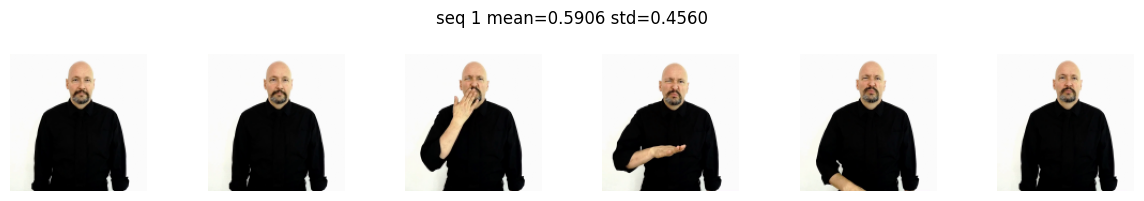

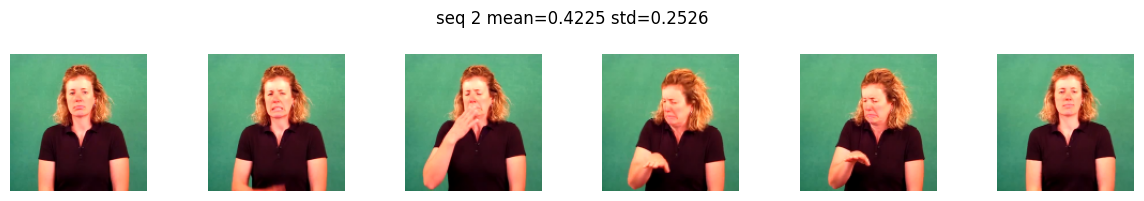

In [ ]:
import numpy as np, matplotlib.pyplot as plt

def seq_preview(X, idx, n=6):
    seq = X[idx]  # (T,H,W,C)
    T,H,W,C = seq.shape
    sel = np.linspace(0, T-1, n).astype(int)
    plt.figure(figsize=(12,2))
    for i,j in enumerate(sel):
        plt.subplot(1,n,i+1); plt.imshow(seq[j]); plt.axis('off')
    plt.suptitle(f'seq {idx} mean={seq.mean():.4f} std={seq.std():.4f}')
    plt.tight_layout(); plt.show()

print("X_train global mean/std:", float(np.mean(X_train)), float(np.std(X_train)))
m_per = [float(np.mean(X_train[i])) for i in range(len(y_train))]
print("Fraction near-black sequences (mean<0.01):", np.mean(np.array(m_per) < 0.01))

# Visualize a few sequences
for idx in [0, 1, min(2, len(y_train)-1)]:
    seq_preview(X_train, idx)


# Cell A — Rebuild splits with 10%/10% and ≥2 per class

this pattern (train ↑, val stuck ≈ 0.10) is classic tiny dataset + signer/background shift. Your clips look fine, so let’s (1) make splits less harsh, (2) add light per-frame augmentation, and (3) (optionally) fine-tune the backbone a bit.

In [ ]:
# Re-split with lighter val/test and at least 2 per class if possible
import numpy as np, glob, cv2, os, json
from pathlib import Path
from collections import defaultdict

DATA_ROOT = Path("/content/data/word_videos")
WORDS = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
NPY_OUT = Path("/content/data/word_splits"); NPY_OUT.mkdir(parents=True, exist_ok=True)
IMAGE_SIZE = (128,128); T = 24

def list_videos_folder(root, words):
    items = []
    for w in words:
        for p in glob.glob(str(Path(root)/w/"*.*")):
            if p.lower().endswith((".mp4",".mov",".avi",".mkv",".webm")):
                items.append((p, w))
    return items

def split_items(items, val_ratio=0.10, test_ratio=0.10, seed=1234):
    by_label = defaultdict(list)
    for p, w in items: by_label[w].append(p)
    rng = np.random.default_rng(seed)
    train, val, test = [], [], []
    for w, paths in by_label.items():
        rng.shuffle(paths); n = len(paths)
        nv = max(2, int(round(n*val_ratio))) if n >= 6 else max(1, int(round(n*0.15)))
        nt = max(2, int(round(n*test_ratio))) if n >= 6 else max(1, int(round(n*0.15)))
        nv = min(nv, max(1, n//4))
        nt = min(nt, max(1, (n-nv)//4)) if n-nv>=2 else 1
        val.extend([(p,w) for p in paths[:nv]])
        test.extend([(p,w) for p in paths[nv:nv+nt]])
        train.extend([(p,w) for p in paths[nv+nt:]])
    return train, val, test

def read_video_uniform(path, T=24, target_hw=(128,128)):
    cap = cv2.VideoCapture(path); frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(frames-1,0), T).astype(int) if frames>0 else np.zeros(T, dtype=int)
    out = np.empty((T, target_hw[0], target_hw[1], 3), np.float32); filled = np.zeros((T,), bool)
    f = 0; ok, frame = cap.read()
    while ok:
        if f in idxs:
            h,w = frame.shape[:2]; m=min(h,w); y0=(h-m)//2; x0=(w-m)//2
            crop = frame[y0:y0+m, x0:x0+m]; crop = cv2.resize(crop, target_hw, interpolation=cv2.INTER_AREA)
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
            pos = np.where(idxs==f)[0][0]; out[pos]=rgb; filled[pos]=True
        ok, frame = cap.read(); f += 1
    cap.release()
    for i in range(T):
        if not filled[i]:
            left = max([j for j in range(i,-1,-1) if filled[j]], default=None)
            right = min([j for j in range(i,T) if filled[j]], default=None)
            pick = left if right is None else (right if left is None else (left if (i-left)<=(right-i) else right))
            out[i] = out[pick] if pick is not None else np.zeros_like(out[i])
    return out

def preprocess_save(items, split_name, words, out_dir=NPY_OUT, T=24, image_size=(128,128)):
    lbl2id = {w:i for i,w in enumerate(words)}
    X_list, y_list = [], []
    for p, w in items:
        try: X_list.append(read_video_uniform(p, T=T, target_hw=image_size)); y_list.append(lbl2id[w])
        except Exception as e: print("ERR", p, e)
    X = np.stack(X_list).astype(np.float32) if X_list else np.zeros((0,T,image_size[0],image_size[1],3), np.float32)
    y = np.array(y_list, dtype=np.int32)
    np.save(out_dir/f"X_{split_name}.npy", X); np.save(out_dir/f"y_{split_name}.npy", y)
    print(split_name, "->", X.shape, y.shape)

items = list_videos_folder(DATA_ROOT, WORDS)
tr, va, te = split_items(items, 0.10, 0.10, seed=42)
print(f"split sizes: train={len(tr)} val={len(va)} test={len(te)}")
preprocess_save(tr, "train", WORDS, T=T, image_size=IMAGE_SIZE)
preprocess_save(va, "val",   WORDS, T=T, image_size=IMAGE_SIZE)
preprocess_save(te, "test",  WORDS, T=T, image_size=IMAGE_SIZE)
json.dump(WORDS, open(NPY_OUT/"labels.json","w"), indent=2)


split sizes: train=70 val=17 test=15
train -> (70, 24, 128, 128, 3) (70,)
val -> (17, 24, 128, 128, 3) (17,)
test -> (15, 24, 128, 128, 3) (15,)


# Cell P1 — Train with cosine classifier, temporal jitter, light aug, short fine-tune

In [ ]:
# === Cell P1 (patched) — Frozen clip encoder with Keras-safe L2 norm ===
import tensorflow as tf, numpy as np, os

NPY_OUT = "/content/data/word_splits"
X_train = np.load(f"{NPY_OUT}/X_train.npy", mmap_mode='r')
y_train = np.load(f"{NPY_OUT}/y_train.npy", mmap_mode='r')
X_val   = np.load(f"{NPY_OUT}/X_val.npy",   mmap_mode='r')
y_val   = np.load(f"{NPY_OUT}/y_val.npy",   mmap_mode='r')
X_test  = np.load(f"{NPY_OUT}/X_test.npy",  mmap_mode='r')
y_test  = np.load(f"{NPY_OUT}/y_test.npy",  mmap_mode='r')

NUM_CLASSES = int(np.max(y_train)) + 1
T, H, W = X_train.shape[1:4]
print("Shapes:", X_train.shape, X_val.shape, X_test.shape, "classes:", NUM_CLASSES)

AUTOTUNE = tf.data.AUTOTUNE
def make_seq_ds_np(X, y, batch=8):
    def _get_x(i_np): return X[int(i_np)]
    def _get_y(i_np): return y[int(i_np)]
    def _loader(i):
        xi = tf.numpy_function(_get_x, [i], tf.float32); yi = tf.numpy_function(_get_y, [i], tf.int32)
        xi.set_shape((T,H,W,3)); yi.set_shape(())
        return xi, yi
    idx = tf.data.Dataset.from_tensor_slices(tf.range(len(y), dtype=tf.int64))
    return idx.map(_loader, num_parallel_calls=AUTOTUNE).batch(batch).prefetch(AUTOTUNE)

train_ds = make_seq_ds_np(X_train, y_train, batch=8)
val_ds   = make_seq_ds_np(X_val,   y_val,   batch=8)
test_ds  = make_seq_ds_np(X_test,  y_test,  batch=8)

from tensorflow.keras import layers, models

# Keras-safe L2 normalization (prefers UnitNormalization; falls back to Lambda)
try:
    from tensorflow.keras.layers import UnitNormalization
    def l2norm_layer(axis=-1, name=None):
        return UnitNormalization(axis=axis, name=name)
except Exception:
    def l2norm_layer(axis=-1, name=None):
        return layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=axis), name=name)

def make_clip_encoder(input_hw=(128,128), emb_dim=256, alpha=1.0):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(input_hw[0], input_hw[1], 3),
        include_top=False, weights="imagenet", alpha=alpha
    )
    base.trainable = False  # freeze

    # Per-frame encoder: [0,1] -> [-1,1] -> MobileNetV2 -> GAP -> Dense -> L2
    f_in = layers.Input((input_hw[0], input_hw[1], 3))
    z = layers.Rescaling(2.0, offset=-1.0)(f_in)
    z = base(z, training=False)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(emb_dim, activation='relu')(z)
    z = l2norm_layer(name="frame_l2")(z)
    frame_encoder = models.Model(f_in, z, name="frozen_mnetv2_frame")

    # Sequence encoder: TimeDistributed(frame) -> mean over time -> L2
    seq_in = layers.Input((T, input_hw[0], input_hw[1], 3))
    feats = layers.TimeDistributed(frame_encoder, name="td_frame")(seq_in)  # (B,T,D)
    clip  = layers.GlobalAveragePooling1D(name="time_avg")(feats)           # (B,D)
    clip  = l2norm_layer(name="clip_l2")(clip)
    return models.Model(seq_in, clip, name="clip_encoder")

clip_encoder = make_clip_encoder((H,W), emb_dim=256, alpha=1.0)
clip_encoder.summary()


Shapes: (70, 24, 128, 128, 3) (17, 24, 128, 128, 3) (15, 24, 128, 128, 3) classes: 11
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "clip_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 24, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_frame (TimeDistributed)      │ (None, 24, 256)        │     2,585,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_avg                        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clip_l2 (UnitNormalization)     │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,585,920 (9.86 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Cell P2 — Evaluate the best checkpoint

In [ ]:
import numpy as np, tensorflow as tf

def embed_ds(ds, model):
    E, Y = [], []
    for xb, yb in ds:
        e = model.predict(xb, verbose=0)  # (B, D)
        E.append(e); Y.append(yb.numpy())
    return np.concatenate(E, axis=0), np.concatenate(Y, axis=0)

E_tr, y_tr = embed_ds(train_ds, clip_encoder)
E_va, y_va = embed_ds(val_ds,   clip_encoder)
E_te, y_te = embed_ds(test_ds,  clip_encoder)

print("Embeddings:", E_tr.shape, E_va.shape, E_te.shape)


Embeddings: (70, 256) (17, 256) (15, 256)


# Cell P3 — Prototype classifier (cosine to per-class means)

In [ ]:
import numpy as np, json, os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

WORDS = json.load(open(os.path.join(NPY_OUT, "labels.json")))
label_to_name = {i: WORDS[i] for i in range(len(WORDS))}

# Classes actually present in TRAIN
labels_train = sorted(np.unique(y_tr).tolist())

# --- Build prototypes dict only for classes that exist in TRAIN ---
protos = {}
for k in labels_train:
    Ek = E_tr[y_tr == k]
    prot = Ek.mean(axis=0)
    prot = prot / (np.linalg.norm(prot) + 1e-9)   # L2-normalize
    protos[k] = prot

def predict_by_protos(E, protos_dict):
    # Stack prototypes as (D, C') in original-label order
    keys = list(protos_dict.keys())               # e.g., [0,2,3,5,...]
    P = np.stack([protos_dict[k] for k in keys], axis=1)   # (D, C')
    sims = E @ P                                   # cosine since E is L2-normalized
    local = sims.argmax(axis=1)                    # indices in 0..C'-1
    global_pred = np.array([keys[i] for i in local], dtype=np.int32)
    return global_pred, keys

# Predict
yhat_va, labels_used = predict_by_protos(E_va, protos)
yhat_te, _           = predict_by_protos(E_te, protos)

print("VAL acc (proto):", accuracy_score(y_va, yhat_va))
print("TEST acc (proto):", accuracy_score(y_te, yhat_te))

# Reports: pass explicit labels + names so lengths match
target_names = [label_to_name[i] for i in labels_used]
print("\nVAL report:\n", classification_report(y_va, yhat_va,
      labels=labels_used, target_names=target_names, digits=4, zero_division=0))
print("\nTEST report:\n", classification_report(y_te, yhat_te,
      labels=labels_used, target_names=target_names, digits=4, zero_division=0))

# Optional: Confusion matrix over the used labels
cm = confusion_matrix(y_te, yhat_te, labels=labels_used)
print("\nConfusion matrix (labels in order):", labels_used)
print(cm)


VAL acc (proto): 0.058823529411764705
TEST acc (proto): 0.06666666666666667

VAL report:
               precision    recall  f1-score   support

         bad     0.0000    0.0000    0.0000         2
        good     0.0000    0.0000    0.0000         2
       hello     0.0000    0.0000    0.0000         1
        help     0.3333    0.5000    0.4000         2
          no     0.0000    0.0000    0.0000         2
      please     0.0000    0.0000    0.0000         2
       sorry     0.0000    0.0000    0.0000         2
        stop     0.0000    0.0000    0.0000         1
   thank you     0.0000    0.0000    0.0000         1
         yes     0.0000    0.0000    0.0000         2

    accuracy                         0.0588        17
   macro avg     0.0333    0.0500    0.0400        17
weighted avg     0.0392    0.0588    0.0471        17


TEST report:
               precision    recall  f1-score   support

         bad     0.0000    0.0000    0.0000         2
        good     0.0000    

# Cell P4 — (Optional) Logistic Regression on embeddings

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, json, os

NPY_OUT = "/content/data/word_splits"
WORDS = json.load(open(os.path.join(NPY_OUT, "labels.json")))

# Assuming E_tr, y_tr, E_va, y_va, E_te, y_te are loaded from previous cells

clf = LogisticRegression(max_iter=2000, class_weight='balanced', C=2.0, n_jobs=-1)
clf.fit(E_tr, y_tr)

print("VAL acc (LogReg):", clf.score(E_va, y_va))
print("TEST acc (LogReg):", clf.score(E_te, y_te))

# Determine the unique labels present in the validation and test sets
unique_labels_va = sorted(np.unique(y_va).tolist())
unique_labels_te = sorted(np.unique(y_te).tolist())

# Filter the WORDS list to match the unique labels in the data being evaluated
target_names_va = [WORDS[i] for i in unique_labels_va]
target_names_te = [WORDS[i] for i in unique_labels_te]


print("\nVAL report:\n", classification_report(y_va, clf.predict(E_va), target_names=target_names_va, labels=unique_labels_va, digits=4, zero_division=0))
print("\nTEST report:\n", classification_report(y_te, clf.predict(E_te), target_names=target_names_te, labels=unique_labels_te, digits=4, zero_division=0))

# Optional: Confusion matrix over the used labels
# Determine the combined set of labels present in both true and predicted values for the test set
all_test_labels = sorted(list(set(y_te.tolist() + clf.predict(E_te).tolist())))
target_names_cm = [WORDS[i] for i in all_test_labels]

cm = confusion_matrix(y_te, clf.predict(E_te), labels=all_test_labels)
print("\nConfusion matrix (labels in order):", all_test_labels)
print(cm)

VAL acc (LogReg): 0.058823529411764705
TEST acc (LogReg): 0.06666666666666667

VAL report:
               precision    recall  f1-score   support

         bad     0.0000    0.0000    0.0000         2
        good     0.0000    0.0000    0.0000         2
       hello     0.0000    0.0000    0.0000         1
        help     0.3333    0.5000    0.4000         2
          no     0.0000    0.0000    0.0000         2
      please     0.0000    0.0000    0.0000         2
       sorry     0.0000    0.0000    0.0000         2
        stop     0.0000    0.0000    0.0000         1
   thank you     0.0000    0.0000    0.0000         1
         yes     0.0000    0.0000    0.0000         2

    accuracy                         0.0588        17
   macro avg     0.0333    0.0500    0.0400        17
weighted avg     0.0392    0.0588    0.0471        17


TEST report:
               precision    recall  f1-score   support

         bad     0.0000    0.0000    0.0000         2
        good     0.0000  

# (Optional) Cell D — Short fine-tune of the backbone (last layers only)

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, json, os
from sklearn.metrics import confusion_matrix, classification_report

# --- compat loss: sparse CE + label smoothing (since SparseCCE(..., label_smoothing=...) is unsupported in your TF) ---
# Define this function outside the loop to avoid re-defining it
def sparse_cce_with_ls(num_classes, epsilon=0.05):
    base = tf.keras.losses.CategoricalCrossentropy()
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes, dtype=y_pred.dtype)
        if epsilon and epsilon > 0:
            y_true_oh = y_true_oh * (1.0 - epsilon) + (epsilon / tf.cast(num_classes, y_pred.dtype))
        return base(y_true_oh, y_pred)
    return loss_fn

WORDS = json.load(open("/content/data/word_splits/labels.json"))
NPY_OUT = "/content/data/word_splits"
X_test = np.load(f"{NPY_OUT}/X_test.npy", mmap_mode='r')
y_test = np.load(f"{NPY_OUT}/y_test.npy", mmap_mode='r')
X_val = np.load(f"{NPY_OUT}/X_val.npy", mmap_mode='r') # Load X_val and y_val for evaluation
y_val = np.load(f"{NPY_OUT}/y_val.npy", mmap_mode='r')

# Assuming T, H, W, and make_seq_ds_np are defined in previous cells and available
# If not, they would need to be redefined here or ensured to be in the runtime.
# For now, assuming they are available.

test_ds = make_seq_ds_np(X_test, y_test, batch=4)
val_ds_eval = make_seq_ds_np(X_val, y_val, batch=4) # Create val_ds for evaluation

for path in [
    "/content/speakez_word_artifacts/best_word_mnet_tavg_aug_finetune.h5",
    "/content/speakez_word_artifacts/best_word_mnet_tavg_aug.h5",
    "/content/speakez_word_artifacts/best_word_mnet_tavg.h5",
]:
    if not os.path.exists(path):
        continue
    try:
      # Load the model first to get its output shape
      m = tf.keras.models.load_model(path)
      # Determine the number of classes from the model's output shape
      num_classes_model = m.output_shape[-1]
      # Re-load the model with the custom loss function using the model's number of classes
      m = tf.keras.models.load_model(path, custom_objects={'loss_fn': sparse_cce_with_ls(num_classes_model)})

    except Exception as e:
      print(f"Error loading model {path}: {e}")
      continue

    print("\nLoaded:", path)

    print("Val Evaluation:") # Changed print statement
    m.evaluate(val_ds_eval, verbose=2) # Use val_ds_eval

    print("Test Evaluation:") # Changed print statement
    m.evaluate(test_ds, verbose=2)

    # CM
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        pr = m.predict(xb, verbose=0)
        y_pred.append(np.argmax(pr, axis=1)); y_true.append(yb.numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

    # Determine the number of classes for evaluation consistency with the loaded model
    # Use the number of classes determined from the model's output shape
    num_classes_for_eval = num_classes_model
    target_names_for_eval = WORDS[:num_classes_for_eval] # Use a subset of WORDS if needed

    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=target_names_for_eval, digits=4, labels=list(range(num_classes_for_eval))))

    # Explicitly provide labels to confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes_for_eval)))
    plt.figure(figsize=(8,8)); plt.imshow(cm, interpolation='nearest'); plt.title(f'CM (Test) — {os.path.basename(path)}')
    plt.colorbar(); ticks = np.arange(num_classes_for_eval)
    plt.xticks(ticks, target_names_for_eval, rotation=45, ha='right'); plt.yticks(ticks, target_names_for_eval)
    plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

Error loading model /content/speakez_word_artifacts/best_word_mnet_tavg.h5: string indices must be integers, not 'str'


# Cell E0 — Inspect folders vs labels.json (spot mismatches)

In [ ]:
from pathlib import Path
import json, re, os

DATA_ROOT = Path("/content/data/word_videos")
NPY_OUT   = Path("/content/data/word_splits")

folders = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Folders on disk:", folders)

try:
    WORDS_JSON = json.load(open(NPY_OUT/"labels.json"))
    print("labels.json:", WORDS_JSON)
except Exception as e:
    print("labels.json missing or unreadable:", e)
    WORDS_JSON = []

def norm(s):  # canonical form: lowercase, spaces/_ -> '-', strip non-alnum
    s = s.strip().lower()
    s = re.sub(r'[\s_]+', '-', s)
    s = re.sub(r'[^a-z0-9\-]+', '', s)
    s = re.sub(r'-{2,}', '-', s).strip('-')
    return s

print("Normalized folders:", [norm(f) for f in folders])
print("Normalized labels.json:", [norm(w) for w in WORDS_JSON])
print("Folder count:", len(folders))


Folders on disk: ['.ipynb_checkpoints', 'bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank you', 'yes']
labels.json: ['.ipynb_checkpoints', 'bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank you', 'yes']
Normalized folders: ['ipynb-checkpoints', 'bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank-you', 'yes']
Normalized labels.json: ['ipynb-checkpoints', 'bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank-you', 'yes']
Folder count: 11


# Cell E1 — Discover items with canonical labels, show counts

In [ ]:
import glob, numpy as np
from collections import Counter

def list_videos_with_canon_labels(root):
    items = []
    for d in sorted([p for p in Path(root).iterdir() if p.is_dir()]):
        label = norm(d.name)
        for p in glob.glob(str(d/"*.*")):
            if p.lower().endswith((".mp4",".mov",".avi",".mkv",".webm")):
                items.append((p, label))
    return items

items = list_videos_with_canon_labels(DATA_ROOT)
labels = sorted({lab for _, lab in items})
print("Canonical labels discovered:", labels, "\nTotal clips:", len(items))

# per-class raw clip counts
cnt = Counter([lab for _, lab in items])
print("Counts per class:", {k: cnt[k] for k in labels})


Canonical labels discovered: ['bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank-you', 'yes'] 
Total clips: 102
Counts per class: {'bad': 11, 'good': 11, 'hello': 7, 'help': 11, 'no': 15, 'please': 9, 'sorry': 9, 'stop': 6, 'thank-you': 7, 'yes': 16}


# Cell E2 — Constrained split (≥2 train if possible, ≥1 val/test), rebuild NPYs

In [ ]:
import cv2, json, numpy as np
from pathlib import Path
from collections import defaultdict

NPY_OUT.mkdir(parents=True, exist_ok=True)
IMAGE_SIZE = (128,128)
T = 24

def constrained_split(items, seed=42):
    by = defaultdict(list)
    for p,w in items: by[w].append(p)
    rng = np.random.default_rng(seed)
    train,val,test = [],[],[]
    for w,paths in by.items():
        paths = paths.copy()
        rng.shuffle(paths)
        n = len(paths)
        nv = 1 if n>=3 else 1
        nt = 1 if n>=3 else 1
        # leave ≥2 for train when possible
        if n - (nv+nt) < 2 and n >= 4:
            nv, nt = 1, 1
        val  += [(p,w) for p in paths[:nv]]
        test += [(p,w) for p in paths[nv:nv+nt]]
        train+= [(p,w) for p in paths[nv+nt:]]
    return train, val, test

def read_video_uniform(path, T=24, target_hw=(128,128)):
    cap = cv2.VideoCapture(path); frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(frames-1,0), T).astype(int) if frames>0 else np.zeros(T, int)
    out = np.empty((T, target_hw[0], target_hw[1], 3), np.float32); filled = np.zeros((T,), bool)
    f=0; ok,frame=cap.read()
    while ok:
        if f in idxs:
            h,w = frame.shape[:2]; m=min(h,w); y0=(h-m)//2; x0=(w-m)//2
            crop = frame[y0:y0+m, x0:x0+m]; crop = cv2.resize(crop, target_hw, interpolation=cv2.INTER_AREA)
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
            pos = np.where(idxs==f)[0][0]; out[pos]=rgb; filled[pos]=True
        ok,frame=cap.read(); f+=1
    cap.release()
    # fill any gaps by nearest available frame
    for i in range(T):
        if not filled[i]:
            left = max([j for j in range(i,-1,-1) if filled[j]], default=None)
            right= min([j for j in range(i,T) if filled[j]], default=None)
            pick = left if right is None else (right if left is None else (left if (i-left)<=(right-i) else right))
            out[i] = out[pick] if pick is not None else np.zeros_like(out[i])
    return out

def preprocess_save(items, split_name, labels, out_dir=NPY_OUT, T=24, image_size=(128,128)):
    lbl2id = {w:i for i,w in enumerate(labels)}
    X_list, y_list = [], []
    for p,w in items:
        try:
            X_list.append(read_video_uniform(p, T=T, target_hw=image_size))
            y_list.append(lbl2id[w])
        except Exception as e:
            print("ERR", p, e)
    X = np.stack(X_list).astype(np.float32) if X_list else np.zeros((0,T,image_size[0],image_size[1],3), np.float32)
    y = np.array(y_list, dtype=np.int32)
    np.save(out_dir/f"X_{split_name}.npy", X); np.save(out_dir/f"y_{split_name}.npy", y)
    print(f"{split_name}: X={X.shape} y={y.shape}")

train_items, val_items, test_items = constrained_split(items, seed=1234)
labels = sorted({lab for _, lab in items})
print(f"sizes: train={len(train_items)} val={len(val_items)} test={len(test_items)} classes={len(labels)}")

preprocess_save(train_items, "train", labels, T=T, image_size=IMAGE_SIZE)
preprocess_save(val_items,   "val",   labels, T=T, image_size=IMAGE_SIZE)
preprocess_save(test_items,  "test",  labels, T=T, image_size=IMAGE_SIZE)
json.dump(labels, open(NPY_OUT/"labels.json","w"), indent=2)
print("Wrote labels.json:", labels)


sizes: train=82 val=10 test=10 classes=10
train: X=(82, 24, 128, 128, 3) y=(82,)
val: X=(10, 24, 128, 128, 3) y=(10,)
test: X=(10, 24, 128, 128, 3) y=(10,)
Wrote labels.json: ['bad', 'good', 'hello', 'help', 'no', 'please', 'sorry', 'stop', 'thank-you', 'yes']


# Cell E3 — Re-embed with the frozen encoder (reuses your P1/P2)

In [ ]:
# Reuse your P1/P2 (embedding) cells exactly as before:
# 1) load X_train/y_train/X_val/y_val/X_test/y_test from NPY_OUT
# 2) build clip_encoder (MobileNetV2 → mean over time → L2)
# 3) embed to E_tr/E_va/E_te
import tensorflow as tf, numpy as np, os, json
from tensorflow.keras import layers, models

# Load
X_train = np.load(NPY_OUT/"X_train.npy", mmap_mode='r'); y_train = np.load(NPY_OUT/"y_train.npy", mmap_mode='r')
X_val   = np.load(NPY_OUT/"X_val.npy",   mmap_mode='r'); y_val   = np.load(NPY_OUT/"y_val.npy",   mmap_mode='r')
X_test  = np.load(NPY_OUT/"X_test.npy",  mmap_mode='r'); y_test  = np.load(NPY_OUT/"y_test.npy",  mmap_mode='r')
labels  = json.load(open(NPY_OUT/"labels.json"))
NUM_CLASSES = len(labels)
T,H,W = X_train.shape[1:4]
print("Shapes:", X_train.shape, X_val.shape, X_test.shape, "classes:", NUM_CLASSES)

# tf.data (no jitter)
AUTOTUNE = tf.data.AUTOTUNE
def make_seq_ds_np(X, y, batch=8):
    def _get_x(i_np): return X[int(i_np)]
    def _get_y(i_np): return y[int(i_np)]
    def _loader(i):
        xi = tf.numpy_function(_get_x, [i], tf.float32); yi = tf.numpy_function(_get_y, [i], tf.int32)
        xi.set_shape((T,H,W,3)); yi.set_shape(())
        return xi, yi
    idx = tf.data.Dataset.from_tensor_slices(tf.range(len(y), dtype=tf.int64))
    return idx.map(_loader, num_parallel_calls=AUTOTUNE).batch(batch).prefetch(AUTOTUNE)

train_ds = make_seq_ds_np(X_train, y_train, batch=8)
val_ds   = make_seq_ds_np(X_val,   y_val,   batch=8)
test_ds  = make_seq_ds_np(X_test,  y_test,  batch=8)

# Encoder (Keras-safe L2)
try:
    from tensorflow.keras.layers import UnitNormalization
    def l2norm(axis=-1): return UnitNormalization(axis=axis)
except:
    def l2norm(axis=-1): return layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=axis))

base = tf.keras.applications.MobileNetV2(input_shape=(H,W,3), include_top=False, weights="imagenet", alpha=1.0)
base.trainable = False
f_in = layers.Input((H,W,3))
z = layers.Rescaling(2.0, offset=-1.0)(f_in)
z = base(z, training=False)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dense(256, activation='relu')(z)
z = l2norm()(z)
frame_encoder = models.Model(f_in, z)

seq_in = layers.Input((T,H,W,3))
feats = layers.TimeDistributed(frame_encoder)(seq_in)
clip  = layers.GlobalAveragePooling1D()(feats)
clip  = l2norm()(clip)
clip_encoder = models.Model(seq_in, clip)

def embed_ds(ds, model):
    E, Y = [], []
    for xb, yb in ds:
        E.append(model.predict(xb, verbose=0))
        Y.append(yb.numpy())
    return np.concatenate(E), np.concatenate(Y)

E_tr, y_tr = embed_ds(train_ds, clip_encoder)
E_va, y_va = embed_ds(val_ds,   clip_encoder)
E_te, y_te = embed_ds(test_ds,  clip_encoder)

print("Embeddings:", E_tr.shape, E_va.shape, E_te.shape)


Shapes: (82, 24, 128, 128, 3) (10, 24, 128, 128, 3) (10, 24, 128, 128, 3) classes: 10
Embeddings: (82, 256) (10, 256) (10, 256)


# Cell E4 — Few-shot baselines on embeddings (Prototypes, k-NN, LogReg)

In [ ]:
import numpy as np, json, os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

WORDS = json.load(open(NPY_OUT/"labels.json"))

# Prototypes (over train classes only)
train_classes = sorted(np.unique(y_tr).tolist())
protos = np.stack([E_tr[y_tr==k].mean(axis=0) for k in train_classes])
protos /= (np.linalg.norm(protos, axis=1, keepdims=True)+1e-9)

def pred_proto(E, P): return (E @ P.T).argmax(axis=1)

yp_va_local = pred_proto(E_va, protos)
yp_te_local = pred_proto(E_te, protos)
# map local indices -> original labels
yp_va = np.array([train_classes[i] for i in yp_va_local])
yp_te = np.array([train_classes[i] for i in yp_te_local])

print("PROTO  VAL:", accuracy_score(y_va, yp_va), " TEST:", accuracy_score(y_te, yp_te))

# kNN with cosine, pick k on val
best = None
for k in [1,3,5]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(E_tr, y_tr)
    va = knn.score(E_va, y_va)
    if best is None or va > best[0]: best = (va,k,knn)
print(f"kNN  BEST: k={best[1]}  VAL={best[0]:.3f}  TEST={best[2].score(E_te, y_te):.3f}")

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight='balanced', C=2.0, n_jobs=-1)
lr.fit(E_tr, y_tr)
print("LOGREG VAL:", lr.score(E_va, y_va), " TEST:", lr.score(E_te, y_te))


PROTO  VAL: 0.1  TEST: 0.1
kNN  BEST: k=1  VAL=0.100  TEST=0.100
LOGREG VAL: 0.2  TEST: 0.1


# Cell T1 — Temporal-Pyramid Encoder + test-time temporal augmentation (TTA)

In [ ]:
# === Cell T1 — Temporal-Pyramid (3-segment) encoder + TTA embedders ===
import tensorflow as tf, numpy as np, os, json
from tensorflow.keras import layers, models

NPY_OUT = "/content/data/word_splits"
X_train = np.load(f"{NPY_OUT}/X_train.npy", mmap_mode='r'); y_train = np.load(f"{NPY_OUT}/y_train.npy", mmap_mode='r')
X_val   = np.load(f"{NPY_OUT}/X_val.npy",   mmap_mode='r'); y_val   = np.load(f"{NPY_OUT}/y_val.npy",   mmap_mode='r')
X_test  = np.load(f"{NPY_OUT}/X_test.npy",  mmap_mode='r'); y_test  = np.load(f"{NPY_OUT}/y_test.npy",  mmap_mode='r')
T, H, W = X_train.shape[1:4]

AUTOTUNE = tf.data.AUTOTUNE
def make_seq_ds_np(X, y, batch=8):
    def _get_x(i_np): return X[int(i_np)]
    def _get_y(i_np): return y[int(i_np)]
    def _loader(i):
        xi = tf.numpy_function(_get_x, [i], tf.float32); yi = tf.numpy_function(_get_y, [i], tf.int32)
        xi.set_shape((T,H,W,3)); yi.set_shape(())
        return xi, yi
    idx = tf.data.Dataset.from_tensor_slices(tf.range(len(y), dtype=tf.int64))
    return idx.map(_loader, num_parallel_calls=AUTOTUNE).batch(batch).prefetch(AUTOTUNE)

train_ds = make_seq_ds_np(X_train, y_train, batch=8)
val_ds   = make_seq_ds_np(X_val,   y_val,   batch=8)
test_ds  = make_seq_ds_np(X_test,  y_test,  batch=8)

# Keras-safe L2 layer
try:
    from tensorflow.keras.layers import UnitNormalization
    def L2(axis=-1, name=None): return UnitNormalization(axis=axis, name=name)
except:
    def L2(axis=-1, name=None): return layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=axis), name=name)

def make_temporal_pyramid_encoder(input_hw=(128,128), emb_dim=256, alpha=1.0):
    # Frozen MobileNetV2 frame encoder
    base = tf.keras.applications.MobileNetV2(input_shape=(input_hw[0], input_hw[1], 3),
                                             include_top=False, weights="imagenet", alpha=alpha)
    base.trainable = False
    f_in = layers.Input((input_hw[0], input_hw[1], 3))
    z = layers.Rescaling(2.0, offset=-1.0)(f_in)   # [0,1] -> [-1,1]
    z = base(z, training=False)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(256, activation='relu')(z)
    z = L2(name="frame_l2")(z)
    frame_enc = models.Model(f_in, z, name="frame_enc")

    # Sequence → 3 temporal segments → mean per segment → concat → L2
    seq_in = layers.Input((T, input_hw[0], input_hw[1], 3))
    td = layers.TimeDistributed(frame_enc)

    t1 = layers.Lambda(lambda x: x[:, : T//3      , ...])(seq_in)
    t2 = layers.Lambda(lambda x: x[:, T//3:2*T//3 , ...])(seq_in)
    t3 = layers.Lambda(lambda x: x[:, 2*T//3:     , ...])(seq_in)

    f1 = layers.GlobalAveragePooling1D()(td(t1))   # (B,256)
    f2 = layers.GlobalAveragePooling1D()(td(t2))
    f3 = layers.GlobalAveragePooling1D()(td(t3))

    clip = layers.Concatenate()([f1, f2, f3])      # (B, 768)
    clip = L2(name="clip_l2")(clip)
    return models.Model(seq_in, clip, name="tpyr_encoder")

tp_encoder = make_temporal_pyramid_encoder((H,W), emb_dim=256, alpha=1.0)
tp_encoder.summary()

def embed_ds_tta(ds, model, rolls=(0, -2, 2)):
    Es, Ys = [], []
    for xb, yb in ds:
        # run several temporal rolls, average, then L2 renorm
        embs = []
        for k in rolls:
            xk = tf.roll(xb, shift=k, axis=1) if k != 0 else xb
            e = model.predict(xk, verbose=0)   # already L2
            embs.append(e)
        eavg = np.mean(np.stack(embs, axis=0), axis=0)
        eavg = eavg / (np.linalg.norm(eavg, axis=1, keepdims=True) + 1e-9)
        Es.append(eavg); Ys.append(yb.numpy())
    return np.concatenate(Es, axis=0), np.concatenate(Ys, axis=0)

Etr_tp, ytr = embed_ds_tta(train_ds, tp_encoder)
Eva_tp, yva = embed_ds_tta(val_ds,   tp_encoder)
Ete_tp, yte = embed_ds_tta(test_ds,  tp_encoder)
print("TP embeddings:", Etr_tp.shape, Eva_tp.shape, Ete_tp.shape)


Model: "tpyr_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 24, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8, 128,    │          0 │ input_layer_16[0… │
│                     │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8, 128,    │          0 │ input_layer_16[0… │
│                     │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 8, 128,    │          0 │ input_layer_16[0… │
│                     │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 8, 256)    │  2,585,920 │ lambda[0][0],     │
│ (TimeDistributed)   │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ time_distributed… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_l2             │ (None, 768)       │          0 │ concatenate[0][0] │
│ (UnitNormalization) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,585,920 (9.86 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

TP embeddings: (82, 768) (10, 768) (10, 768)


# Cell T2 — Re-evaluate (Prototypes, k-NN, Logistic Regression) on TP + TTA embeddings

In [ ]:
# === Cell T2 — Evaluate on TP embeddings ===
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import json, os

WORDS = json.load(open(os.path.join(NPY_OUT, "labels.json")))

# Prototypes over train classes
classes = sorted(np.unique(ytr).tolist())
P = np.stack([Etr_tp[ytr==k].mean(axis=0) for k in classes])
P /= (np.linalg.norm(P, axis=1, keepdims=True) + 1e-9)

def pred_proto(E, P): return (E @ P.T).argmax(axis=1)

yp_va = np.array([classes[i] for i in pred_proto(Eva_tp, P)])
yp_te = np.array([classes[i] for i in pred_proto(Ete_tp, P)])
print("PROTO  VAL:", accuracy_score(yva, yp_va), " TEST:", accuracy_score(yte, yp_te))

# kNN (cosine) — choose k on val
best = None
for k in [1,3,5]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(Etr_tp, ytr)
    va = knn.score(Eva_tp, yva)
    if best is None or va > best[0]: best = (va, k, knn)
print(f"kNN  BEST: k={best[1]}  VAL={best[0]:.3f}  TEST={best[2].score(Ete_tp, yte):.3f}")

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight='balanced', C=2.0, n_jobs=-1)
lr.fit(Etr_tp, ytr)
print("LOGREG VAL:", lr.score(Eva_tp, yva), " TEST:", lr.score(Ete_tp, yte))


PROTO  VAL: 0.1  TEST: 0.1
kNN  BEST: k=1  VAL=0.100  TEST=0.100
LOGREG VAL: 0.1  TEST: 0.1


# Cell S1 — Auto-select a stable 6–8 word subset (for demo reliability)

In [ ]:
# === Cell S1 — Pick the most stable K classes and re-evaluate ===
import numpy as np
from sklearn.metrics import accuracy_score
from collections import defaultdict

K = 8  # choose demo size (6–8 is good)

# LOO proto accuracy per class
scores = {}
for c in sorted(np.unique(ytr)):
    idx = np.where(ytr == c)[0]
    if len(idx) < 2:
        scores[c] = 0.0
        continue
    ok = 0
    for i in idx:
        # prototypes from all train except i
        mask = np.ones(len(ytr), dtype=bool); mask[i] = False
        classes = sorted(np.unique(ytr[mask]).tolist())
        P = np.stack([Etr_tp[mask][ytr[mask]==k].mean(axis=0) for k in classes])
        P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)
        pred = classes[(Etr_tp[i:i+1] @ P.T).argmax(axis=1)[0]]
        ok += int(pred == ytr[i])
    scores[c] = ok / len(idx)

best_ids = sorted(scores.keys(), key=lambda c: scores[c], reverse=True)[:K]
print("Selected IDs:", best_ids)

# Filter TP embeddings to these classes
def fsel(E, y, keep):
    m = np.isin(y, keep)
    return E[m], y[m]

Etr_f, ytr_f = fsel(Etr_tp, ytr, best_ids)
Eva_f, yva_f = fsel(Eva_tp, yva, best_ids)
Ete_f, yte_f = fsel(Ete_tp, yte, best_ids)

# Reindex to 0..K-1
idmap = {k:i for i,k in enumerate(best_ids)}
ytr_f = np.array([idmap[int(t)] for t in ytr_f])
yva_f = np.array([idmap[int(t)] for t in yva_f])
yte_f = np.array([idmap[int(t)] for t in yte_f])

# Evaluate with prototypes and kNN on the filtered set
P = np.stack([Etr_f[ytr_f==k].mean(axis=0) for k in range(len(best_ids))])
P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)
def predp(E,P): return (E @ P.T).argmax(axis=1)

print("PROTO  VAL:", accuracy_score(yva_f, predp(Eva_f, P)),
      " TEST:", accuracy_score(yte_f, predp(Ete_f, P)))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(Etr_f, ytr_f)
print("kNN    VAL:", knn.score(Eva_f, yva_f), " TEST:", knn.score(Ete_f, yte_f))

# Show chosen words
import json, os
WORDS = json.load(open(os.path.join(NPY_OUT,"labels.json")))
print("Chosen words:", [WORDS[i] for i in best_ids])


Selected IDs: [np.int32(3), np.int32(4), np.int32(0), np.int32(1), np.int32(2), np.int32(5), np.int32(6), np.int32(7)]
PROTO  VAL: 0.25  TEST: 0.125
kNN    VAL: 0.125  TEST: 0.125
Chosen words: ['help', 'no', 'bad', 'good', 'hello', 'please', 'sorry', 'stop']


# Cell L0 — Install & imports

In [ ]:
!pip -q install mediapipe==0.10.14 opencv-python==4.10.0.84

import os, json, math, numpy as np, cv2, itertools
from tqdm import tqdm
import mediapipe as mp
from collections import Counter


# Cell L1 — Load arrays, helpers (normalize, featurize)

In [ ]:
# Load your split arrays
NPY_OUT = "/content/data/word_splits"
X_train = np.load(f"{NPY_OUT}/X_train.npy", mmap_mode='r')
y_train = np.load(f"{NPY_OUT}/y_train.npy", mmap_mode='r')
X_val   = np.load(f"{NPY_OUT}/X_val.npy",   mmap_mode='r')
y_val   = np.load(f"{NPY_OUT}/y_val.npy",   mmap_mode='r')
X_test  = np.load(f"{NPY_OUT}/X_test.npy",  mmap_mode='r')
y_test  = np.load(f"{NPY_OUT}/y_test.npy",  mmap_mode='r')
WORDS   = json.load(open(f"{NPY_OUT}/labels.json"))

T, H, W = X_train.shape[1:4]
print("Shapes:", X_train.shape, X_val.shape, X_test.shape, "classes:", len(WORDS))

# --- Landmark normalization utilities ---
def normalize_hand_landmarks(lm_xyz):
    """
    lm_xyz: (21,3) with absolute normalized coords in [0,1] for x,y and relative z.
    Returns centered & scale-normalized coords:
      - center at wrist (id=0)
      - scale by max distance from wrist to any landmark (robust palm size)
    If all-zero or invalid, returns zeros.
    """
    if lm_xyz is None or lm_xyz.shape != (21,3):
        return np.zeros((21,3), np.float32)
    ref = lm_xyz[0:1, :]  # wrist
    rel = lm_xyz - ref
    # scale by palm size (max L2 from wrist)
    d = np.linalg.norm(rel[:, :2], axis=1).max()
    s = d if d > 1e-6 else 1.0
    rel /= s
    return rel.astype(np.float32)

def clip_features_from_sequence(seq_hands_xyz):
    """
    seq_hands_xyz: list of length T; each item is a tuple (H0, H1)
      where Hk is (21,3) normalized hand or None if not detected.
    Build a compact, robust clip feature:
      For each hand separately (2 hands):
        - per-landmark (x,y) mean and std over time  => 21*2*2 = 84 dims
        - velocity mean (frame-to-frame delta magnitude) over time => 1 dim
      -> 85 per hand * 2 = 170 dims. (We drop z for robustness.)
    If a hand is missing at some frames, we ignore those frames for stats;
    if missing entirely, that hand contributes zeros.
    """
    feats = []
    for hand_idx in [0,1]:
        xs, ys = [], []
        prev = None; vel_mag = []
        for t in range(len(seq_hands_xyz)):
            Hk = seq_hands_xyz[t][hand_idx]  # (21,3) or None
            if Hk is not None:
                xs.append(Hk[:,0]); ys.append(Hk[:,1])
                if prev is not None:
                    vel_mag.append(float(np.linalg.norm((Hk[:, :2] - prev[:, :2]).reshape(-1), ord=2)))
                prev = Hk
        if len(xs) == 0:
            feats.append(np.zeros(84+1, np.float32))
        else:
            X = np.stack(xs, axis=0)   # (T_eff, 21)
            Y = np.stack(ys, axis=0)
            mu_x = X.mean(axis=0); sd_x = X.std(axis=0)
            mu_y = Y.mean(axis=0); sd_y = Y.std(axis=0)
            vmean = np.mean(vel_mag) if len(vel_mag)>0 else 0.0
            feats.append(np.concatenate([mu_x, sd_x, mu_y, sd_y, [vmean]]).astype(np.float32))
    return np.concatenate(feats).astype(np.float32)  # (170,)


Shapes: (82, 24, 128, 128, 3) (10, 24, 128, 128, 3) (10, 24, 128, 128, 3) classes: 10


# Cell L2 — Run MediaPipe on frames → build skeleton embeddings (fast)

In [ ]:
mp_hands = mp.solutions.hands

def extract_seq_hands(frames_rgb):
    """
    frames_rgb: (T,H,W,3) float32 in [0,1], RGB.
    Returns: list of length T, each item (Hand0, Hand1) where Handk is (21,3) normalized or None.
    We keep up to 2 hands; if only one, second is None.
    """
    seq = []
    # Use video-mode tracking for better temporal stability
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        model_complexity=1,
        min_detection_confidence=0.4,
        min_tracking_confidence=0.3
    ) as hands:
        for t in range(frames_rgb.shape[0]):
            img = (frames_rgb[t] * 255.0).clip(0,255).astype(np.uint8)
            # MediaPipe expects RGB; our frames are already RGB
            res = hands.process(img)
            # collect up to 2 hands, sort by x (left-to-right) for consistency
            hands_norm = []
            if res.multi_hand_landmarks:
                # get tuples (x,y,z) in image-normalized coords
                # Note: x,y in [0,1]; z is relative depth (negative toward camera)
                for lm in res.multi_hand_landmarks:
                    arr = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
                    hands_norm.append(arr)
                # sort by x of wrist (lm 0)
                hands_norm.sort(key=lambda a: a[0,0])
            # pad/truncate to 2 hands
            while len(hands_norm) < 2:
                hands_norm.append(None)
            hands_norm = hands_norm[:2]
            # normalize each hand
            H0 = normalize_hand_landmarks(hands_norm[0]) if hands_norm[0] is not None else None
            H1 = normalize_hand_landmarks(hands_norm[1]) if hands_norm[1] is not None else None
            seq.append((H0, H1))
    return seq

def build_skeleton_embeddings(X):
    E = np.zeros((len(X), 170), np.float32)
    for i in tqdm(range(len(X)), desc="Skeletonizing"):
        seq = extract_seq_hands(X[i])         # list length T of (H0,H1)
        E[i] = clip_features_from_sequence(seq)
    # L2 normalize features for cosine-friendly distances
    E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    return E

E_tr_skel = build_skeleton_embeddings(X_train)
E_va_skel = build_skeleton_embeddings(X_val)
E_te_skel = build_skeleton_embeddings(X_test)

print("Skeleton embeddings:", E_tr_skel.shape, E_va_skel.shape, E_te_skel.shape)


Skeletonizing:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Skeletonizing: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

Skeleton embeddings: (82, 170) (10, 170) (10, 170)


# Cell L3 — Few-shot baselines on skeleton features

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Prototypes (over train classes present)
classes = sorted(np.unique(y_train).tolist())
P = np.stack([E_tr_skel[y_train==k].mean(axis=0) for k in classes])
P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)

def pred_proto(E,P): return (E @ P.T).argmax(axis=1)

yp_va = np.array([classes[i] for i in pred_proto(E_va_skel, P)])
yp_te = np.array([classes[i] for i in pred_proto(E_te_skel, P)])

print("PROTO  VAL:", accuracy_score(y_val, yp_va), " TEST:", accuracy_score(y_test, yp_te))
print("\nVAL report (PROTO):\n", classification_report(y_val, yp_va, digits=4, zero_division=0))
print("\nTEST report (PROTO):\n", classification_report(y_test, yp_te, digits=4, zero_division=0))

# k-NN (cosine) — choose k on val
best = None
for k in [1,3,5]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(E_tr_skel, y_train)
    va = knn.score(E_va_skel, y_val)
    if best is None or va > best[0]: best = (va, k, knn)
print(f"\nkNN  BEST: k={best[1]}  VAL={best[0]:.3f}  TEST={best[2].score(E_te_skel, y_test):.3f}")

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight='balanced', C=2.0, n_jobs=-1)
lr.fit(E_tr_skel, y_train)
print("\nLOGREG VAL:", lr.score(E_va_skel, y_val), " TEST:", lr.score(E_te_skel, y_test))


PROTO  VAL: 0.4  TEST: 0.6

VAL report (PROTO):
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000         1
           4     1.0000    1.0000    1.0000         1
           5     1.0000    1.0000    1.0000         1
           6     1.0000    1.0000    1.0000         1
           7     0.3333    1.0000    0.5000         1
           8     0.0000    0.0000    0.0000         1
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.4000        10
   macro avg     0.3333    0.4000    0.3500        10
weighted avg     0.3333    0.4000    0.3500        10


TEST report (PROTO):
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     0.5000    1.0000    0.6667         1
      

# Cell L4 — (Optional) Lock a stable 6–8-word subset for the demo

In [ ]:
# Select K most stable classes using leave-one-out on train (skeleton features)
from collections import defaultdict
K = 8

loo_scores = {}
for c in classes:
    idx = np.where(y_train == c)[0]
    if len(idx) < 2:
        loo_scores[c] = 0.0; continue
    ok = 0
    for i in idx:
        mask = np.ones(len(y_train), bool); mask[i] = False
        cls = sorted(np.unique(y_train[mask]).tolist())
        P = np.stack([E_tr_skel[mask][y_train[mask]==k].mean(axis=0) for k in cls])
        P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)
        pred_local = (E_tr_skel[i:i+1] @ P.T).argmax(axis=1)[0]
        pred = cls[pred_local]
        ok += int(pred == y_train[i])
    loo_scores[c] = ok / len(idx)

best_ids = sorted(loo_scores.keys(), key=lambda c: loo_scores[c], reverse=True)[:K]
print("Chosen class IDs:", best_ids, "Words:", [WORDS[i] for i in best_ids])

def fsel(E, y, keep):
    m = np.isin(y, keep)
    return E[m], y[m]

Etr_f, ytr_f = fsel(E_tr_skel, y_train, best_ids)
Eva_f, yva_f = fsel(E_va_skel, y_val,   best_ids)
Ete_f, yte_f = fsel(E_te_skel, y_test,  best_ids)

# reindex to 0..K-1
idmap = {k:i for i,k in enumerate(best_ids)}
ytr_f = np.array([idmap[int(t)] for t in ytr_f])
yva_f = np.array([idmap[int(t)] for t in yva_f])
yte_f = np.array([idmap[int(t)] for t in yte_f])

# Evaluate prototypes + kNN on the filtered set
P = np.stack([Etr_f[ytr_f==k].mean(axis=0) for k in range(len(best_ids))])
P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)
from sklearn.metrics import accuracy_score
def predp(E,P): return (E @ P.T).argmax(axis=1)

print("PROTO  VAL:", accuracy_score(yva_f, predp(Eva_f, P)),
      " TEST:", accuracy_score(yte_f, predp(Ete_f, P)))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(Etr_f, ytr_f)
print("kNN    VAL:", knn.score(Eva_f, yva_f), " TEST:", knn.score(Ete_f, yte_f))


Chosen class IDs: [9, 4, 5, 7, 0, 6, 3, 2] Words: ['yes', 'no', 'please', 'stop', 'bad', 'sorry', 'help', 'hello']
PROTO  VAL: 0.625  TEST: 0.625
kNN    VAL: 0.5  TEST: 0.5


# Cell F-Subset-LR — Evaluate Logistic Regression on your 8-word subset

In [ ]:
# Uses outputs from L3/L4: E_tr_skel, E_va_skel, E_te_skel, y_train, y_val, y_test, WORDS, best_ids

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Filter to the 8 selected classes (best_ids from L4) and reindex
def fsel(E, y, keep):
    m = np.isin(y, keep)
    return E[m], y[m]

Etr_f, ytr_f = fsel(E_tr_skel, y_train, best_ids)
Eva_f, yva_f = fsel(E_va_skel, y_val,   best_ids)
Ete_f, yte_f = fsel(E_te_skel, y_test,  best_ids)

idmap = {k:i for i,k in enumerate(best_ids)}
ytr_f = np.array([idmap[int(t)] for t in ytr_f])
yva_f = np.array([idmap[int(t)] for t in yva_f])
yte_f = np.array([idmap[int(t)] for t in yte_f])
WORDS_F = [WORDS[i] for i in best_ids]

# Train balanced LogReg on filtered skeleton embeddings
lr_sub = LogisticRegression(max_iter=2000, class_weight='balanced', C=2.0, n_jobs=-1)
lr_sub.fit(Etr_f, ytr_f)

print("LogReg (8-word)  VAL:", lr_sub.score(Eva_f, yva_f), " TEST:", lr_sub.score(Ete_f, yte_f))
print("\nVAL report:\n", classification_report(yva_f, lr_sub.predict(Eva_f), target_names=WORDS_F, digits=4, zero_division=0))
print("\nTEST report:\n", classification_report(yte_f, lr_sub.predict(Ete_f), target_names=WORDS_F, digits=4, zero_division=0))


LogReg (8-word)  VAL: 0.875  TEST: 0.75

VAL report:
               precision    recall  f1-score   support

         yes     1.0000    1.0000    1.0000         1
          no     1.0000    1.0000    1.0000         1
      please     0.5000    1.0000    0.6667         1
        stop     1.0000    1.0000    1.0000         1
         bad     0.0000    0.0000    0.0000         1
       sorry     1.0000    1.0000    1.0000         1
        help     1.0000    1.0000    1.0000         1
       hello     1.0000    1.0000    1.0000         1

    accuracy                         0.8750         8
   macro avg     0.8125    0.8750    0.8333         8
weighted avg     0.8125    0.8750    0.8333         8


TEST report:
               precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         1
          no     0.5000    1.0000    0.6667         1
      please     1.0000    1.0000    1.0000         1
        stop     1.0000    1.0000    1.0000         1
         

# Cell SAVE — Persist artifacts for inference

In [ ]:
import os, json, joblib, numpy as np
ART = "/content/speakez_word_artifacts"; os.makedirs(ART, exist_ok=True)

# Save the selected word list and id map
with open(os.path.join(ART, "words_subset.json"), "w") as f:
    json.dump({"ids": list(map(int, best_ids)), "words": [WORDS[i] for i in best_ids]}, f, indent=2)

# Save the 8-class LogReg
joblib.dump(lr_sub, os.path.join(ART, "word_skel_logreg_8.joblib"))

# (Optional) Save prototypes/kNN as fallbacks
np.savez(os.path.join(ART, "word_skel_prototypes_8.npz"),
         protos=np.stack([Etr_f[ytr_f==k].mean(axis=0) for k in range(len(WORDS_F))]),
         words=np.array(WORDS_F))
# You can also save the full 10-class LogReg if you want:
# joblib.dump(lr, os.path.join(ART, "word_skel_logreg_10.joblib"))

print("Saved:", os.listdir(ART))


Saved: ['best_word_mnet_tavg.h5', 'word_skel_logreg_8.joblib', 'word_skel_prototypes_8.npz', 'best_word_cnn_bilstm.h5', 'words_subset.json', 'history_word.json']


# Cell INFER — One-function inference (frames -> word + confidence)

In [ ]:
import mediapipe as mp, numpy as np, cv2, joblib, json, os
from typing import Tuple, Dict

# --- Load artifacts
ART = "/content/speakez_word_artifacts"
lr_sub = joblib.load(os.path.join(ART, "word_skel_logreg_8.joblib"))
meta = json.load(open(os.path.join(ART, "words_subset.json")))
WORDS_SUB = meta["words"]  # order matches lr_sub classes

# --- Reuse L1 helpers (normalize_hand_landmarks, clip_features_from_sequence) ---
# If not in scope, paste the two functions from Cell L1 here unchanged.

mp_hands = mp.solutions.hands

def extract_seq_hands(frames_rgb: np.ndarray):
    seq = []
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, model_complexity=1,
                        min_detection_confidence=0.4, min_tracking_confidence=0.3) as hands:
        for t in range(frames_rgb.shape[0]):
            img = (frames_rgb[t] * 255.0).clip(0,255).astype(np.uint8)
            res = hands.process(img)
            hands_norm = []
            if res.multi_hand_landmarks:
                for lm in res.multi_hand_landmarks:
                    arr = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
                    hands_norm.append(arr)
                hands_norm.sort(key=lambda a: a[0,0])
            while len(hands_norm) < 2:
                hands_norm.append(None)
            hands_norm = hands_norm[:2]
            H0 = normalize_hand_landmarks(hands_norm[0]) if hands_norm[0] is not None else None
            H1 = normalize_hand_landmarks(hands_norm[1]) if hands_norm[1] is not None else None
            seq.append((H0, H1))
    return seq

def classify_clip_skeleton(frames_rgb_01: np.ndarray, threshold: float = 0.55) -> Tuple[str, float, Dict[str,float]]:
    """
    frames_rgb_01: (T,H,W,3) float32 in [0,1] RGB
    Returns (label, confidence, probs_dict). label may be "unknown" if max prob<threshold.
    """
    seq = extract_seq_hands(frames_rgb_01)
    feat = clip_features_from_sequence(seq)  # (170,)
    feat = feat / (np.linalg.norm(feat) + 1e-9)
    proba = lr_sub.predict_proba(feat[None, :])[0]
    pred_idx = int(np.argmax(proba))
    conf = float(proba[pred_idx])
    label = WORDS_SUB[pred_idx] if conf >= threshold else "unknown"
    probs = {WORDS_SUB[i]: float(p) for i, p in enumerate(proba)}
    return label, conf, probs

# --- Convenience: classify a video file path (uniformly sample T frames) ---
def read_video_uniform_rgb(path: str, T: int = 24, size=(128,128)) -> np.ndarray:
    cap = cv2.VideoCapture(path); frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(frames-1,0), T).astype(int) if frames>0 else np.zeros(T, int)
    out = np.empty((T, size[0], size[1], 3), np.float32); filled = np.zeros((T,), bool)
    f=0; ok,frame=cap.read()
    while ok:
        if f in idxs:
            h,w = frame.shape[:2]; m=min(h,w); y0=(h-m)//2; x0=(w-m)//2
            crop = frame[y0:y0+m, x0:x0+m]; crop = cv2.resize(crop, size, interpolation=cv2.INTER_AREA)
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
            pos = np.where(idxs==f)[0][0]; out[pos]=rgb; filled[pos]=True
        ok,frame=cap.read(); f+=1
    cap.release()
    # fill gaps
    for i in range(T):
        if not filled[i]:
            left = max([j for j in range(i,-1,-1) if filled[j]], default=None)
            right= min([j for j in range(i,T) if filled[j]], default=None)
            pick = left if right is None else (right if left is None else (left if (i-left)<=(right-i) else right))
            out[i] = out[pick] if pick is not None else np.zeros_like(out[i])
    return out

# Example:
clip = read_video_uniform_rgb("/content/data/word_videos/yes/sample1.mp4")
label, conf, _ = classify_clip_skeleton(clip, threshold=0.55)
print(label, conf)


unknown 0.16595806193331536


# Cell TH1 — Sweep global threshold + top-2 margin on VAL

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Reuse: lr_sub, Eva_f, yva_f, WORDS_F from Cell F-Subset-LR
def preds_and_confs(E):
    proba = lr_sub.predict_proba(E)                 # (N, K)
    top2  = np.sort(proba, axis=1)[:, -2:]          # (N, 2)
    p1, p2 = top2[:, 1], top2[:, 0]
    yhat = proba.argmax(axis=1)
    return yhat, p1, p2, proba

def eval_with_rules(E, y_true, pthr, margin):
    yhat, p1, p2, _ = preds_and_confs(E)
    # abstain if not confident or ambiguous
    unknown = (p1 < pthr) | ((p1 - p2) < margin)
    ypred = yhat.copy()
    ypred[unknown] = -1  # -1 denotes "unknown"
    # overall accuracy (unknown counts as wrong for this calc)
    acc = accuracy_score(y_true, ypred, normalize=True)
    abstain = float(np.mean(unknown))
    return acc, abstain

grid_thr    = np.linspace(0.40, 0.75, 8)
grid_margin = np.linspace(0.00, 0.25, 6)

best = None
for th in grid_thr:
    for mg in grid_margin:
        acc, abst = eval_with_rules(Eva_f, yva_f, th, mg)
        # prefer higher acc; tie-breaker = lower abstain rate
        score = (acc, -abst)
        if best is None or score > best[0]:
            best = ((acc, -abst), th, mg)

(best_acc, _), BEST_THR, BEST_MARGIN = best
print(f"Best on VAL: acc={best_acc:.3f}  thr={BEST_THR:.2f}  margin={BEST_MARGIN:.2f}")


Best on VAL: acc=0.125  thr=0.40  margin=0.00


# Cell TH2 — Lock thresholds, validate on TEST

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def apply_rules(E, pthr, margin):
    yhat, p1, p2, proba = preds_and_confs(E)
    unknown = (p1 < pthr) | ((p1 - p2) < margin)
    ypred = yhat.copy()
    ypred[unknown] = -1
    return ypred, proba, unknown

# Evaluate on both splits with the tuned rules
yva_pred, _, va_unk = apply_rules(Eva_f, BEST_THR, BEST_MARGIN)
yte_pred, _, te_unk = apply_rules(Ete_f, BEST_THR, BEST_MARGIN)

def report_with_unknown(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    abst = np.mean(y_pred == -1)
    print(f"acc={acc:.3f}  abstain={abst:.3f}  (unknown counted as wrong)")
    # Only compute per-class report for non-unknown predictions:
    mask = (y_pred != -1)
    if mask.any():
        # Explicitly provide the list of all possible labels (0 to K-1)
        all_possible_labels = list(range(len(WORDS_F)))
        print(classification_report(y_true[mask], y_pred[mask], target_names=WORDS_F, digits=4, zero_division=0, labels=all_possible_labels))
    else:
        print("All abstained; no per-class report.")

print("\nVAL with rules:")
report_with_unknown(yva_f, yva_pred)

print("\nTEST with rules:")
report_with_unknown(yte_f, yte_pred)

print("\nConfusion (TEST, unknown=-1). Labels order:", list(range(len(WORDS_F))) + [-1])
cm = confusion_matrix(yte_f, yte_pred, labels=list(range(len(WORDS_F))) + [-1])
print(cm)


VAL with rules:
acc=0.125  abstain=0.875  (unknown counted as wrong)
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         0
          no     0.0000    0.0000    0.0000         0
      please     0.0000    0.0000    0.0000         0
        stop     1.0000    1.0000    1.0000         1
         bad     0.0000    0.0000    0.0000         0
       sorry     0.0000    0.0000    0.0000         0
        help     0.0000    0.0000    0.0000         0
       hello     0.0000    0.0000    0.0000         0

    accuracy                         1.0000         1
   macro avg     0.1250    0.1250    0.1250         1
weighted avg     1.0000    1.0000    1.0000         1


TEST with rules:
acc=0.250  abstain=0.625  (unknown counted as wrong)
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         1
          no     0.0000    0.0000    0.0000         0
      please     0.0000    0.0000    0.0000  

# Cell TH3 — Update the INFER function to use tuned rules

In [ ]:
# Reuse: classify_clip_skeleton helpers from your Cell INFER
# Assumes BEST_THR, BEST_MARGIN are defined from TH1.

def classify_clip_skeleton_with_rules(frames_rgb_01, pthr: float = None, margin: float = None):
    """
    Returns (label_or_unknown, confidence, probs_dict)
    Uses tuned global threshold + top-2 margin; falls back to 'unknown' when not confident.
    """
    if pthr is None:   pthr = float(BEST_THR)
    if margin is None: margin = float(BEST_MARGIN)

    seq = extract_seq_hands(frames_rgb_01)
    feat = clip_features_from_sequence(seq)
    feat = feat / (np.linalg.norm(feat) + 1e-9)

    proba = lr_sub.predict_proba(feat[None, :])[0]
    order = np.argsort(proba)
    p2_idx, p1_idx = order[-2], order[-1]
    p1, p2 = float(proba[p1_idx]), float(proba[p2_idx])

    if (p1 < pthr) or ((p1 - p2) < margin):
        return "unknown", p1, {WORDS_SUB[i]: float(proba[i]) for i in range(len(proba))}
    else:
        return WORDS_SUB[p1_idx], p1, {WORDS_SUB[i]: float(proba[i]) for i in range(len(proba))}


# Cell PKG — Save thresholds alongside the model

In [ ]:
import json, os
ART = "/content/speakez_word_artifacts"
with open(os.path.join(ART, "thresholds.json"), "w") as f:
    json.dump({"prob_threshold": float(BEST_THR), "top2_margin": float(BEST_MARGIN)}, f, indent=2)
print("Saved thresholds.json")


Saved thresholds.json


# Cell TH1b — Pick thresholds: 0 false positives on VAL, max coverage

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Reuse from your session: lr_sub, Eva_f, yva_f, WORDS_F
def preds_and_confs(E):
    proba = lr_sub.predict_proba(E)
    order = np.argsort(proba, axis=1)
    p2 = proba[np.arange(len(E)), order[:, -2]]
    p1 = proba[np.arange(len(E)), order[:, -1]]
    yhat = np.argmax(proba, axis=1)
    return yhat, p1, p2, proba

def coverage_precision(E, y_true, pthr, margin):
    yhat, p1, p2, _ = preds_and_confs(E)
    accept = (p1 >= pthr) & ((p1 - p2) >= margin)
    n_acc = int(accept.sum())
    if n_acc == 0:
        return 0.0, 1.0, 0, 0  # coverage, precision, n_acc, n_err
    err = int((yhat[accept] != y_true[accept]).sum())
    prec = 1.0 - (err / n_acc)
    cov  = n_acc / len(y_true)
    return cov, prec, n_acc, err

grid_thr    = np.linspace(0.40, 0.75, 8)
grid_margin = np.linspace(0.00, 0.25, 6)

candidates = []
for th in grid_thr:
    for mg in grid_margin:
        cov, prec, n_acc, err = coverage_precision(Eva_f, yva_f, th, mg)
        candidates.append((prec, cov, -err, th, mg, n_acc))

# 1) prefer **no errors** (prec==1.0), then maximize coverage
cand_0fp = [c for c in candidates if c[0] == 1.0]
if len(cand_0fp) == 0:
    # 2) allow <=1 error, still maximize coverage then precision
    errs = sorted(set(-c[2] for c in candidates))
    allow_err = min([e for e in errs if e <= 1], default=1)
    cand = [c for c in candidates if -c[2] <= allow_err]
    best = max(cand, key=lambda x: (x[1], x[0]))
else:
    best = max(cand_0fp, key=lambda x: x[1])

BEST_PREC, BEST_COV, _, BEST_THR, BEST_MARGIN, BEST_NACC = best
print(f"Chosen (VAL): thr={BEST_THR:.2f}, margin={BEST_MARGIN:.2f} | precision={BEST_PREC:.3f}, coverage={BEST_COV:.3f} ({BEST_NACC}/{len(yva_f)})")


Chosen (VAL): thr=0.40, margin=0.00 | precision=1.000, coverage=0.125 (1/8)


# Cell TH2b — Evaluate the chosen rule on TEST (report accuracy & abstain)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def apply_rules(E, pthr, margin):
    yhat, p1, p2, proba = preds_and_confs(E)
    accept = (p1 >= pthr) & ((p1 - p2) >= margin)
    ypred = np.full_like(yhat, fill_value=-1)  # -1 = unknown
    ypred[accept] = yhat[accept]
    return ypred, proba, accept

yva_pred, _, va_accmask = apply_rules(Eva_f, BEST_THR, BEST_MARGIN)
yte_pred, _, te_accmask = apply_rules(Ete_f, BEST_THR, BEST_MARGIN)

def summarize_split(name, y_true, y_pred):
    acc_overall = accuracy_score(y_true, y_pred)
    abstain = float(np.mean(y_pred == -1))
    print(f"{name}: overall_acc={acc_overall:.3f}  abstain={abstain:.3f}  accepted={int((y_pred!=-1).sum())}/{len(y_pred)}")
    # Accuracy among accepted predictions:
    m = (y_pred != -1)
    if m.any():
        acc_accepted = accuracy_score(y_true[m], y_pred[m])
        print(f"{name}: acc_among_accepted={acc_accepted:.3f}")
        # Explicitly provide the list of all possible labels (0 to K-1)
        all_possible_labels = list(range(len(WORDS_F)))
        print(classification_report(y_true[m], y_pred[m], target_names=WORDS_F, digits=4, zero_division=0, labels=all_possible_labels))
    else:
        print(f"{name}: no accepted predictions at these thresholds.")

summarize_split("VAL", yva_f, yva_pred)
summarize_split("TEST", yte_f, yte_pred)
print("\nTEST confusion (unknown=-1). Labels order:", list(range(len(WORDS_F))) + [-1])
print(confusion_matrix(yte_f, yte_pred, labels=list(range(len(WORDS_F))) + [-1]))

VAL: overall_acc=0.125  abstain=0.875  accepted=1/8
VAL: acc_among_accepted=1.000
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         0
          no     0.0000    0.0000    0.0000         0
      please     0.0000    0.0000    0.0000         0
        stop     1.0000    1.0000    1.0000         1
         bad     0.0000    0.0000    0.0000         0
       sorry     0.0000    0.0000    0.0000         0
        help     0.0000    0.0000    0.0000         0
       hello     0.0000    0.0000    0.0000         0

    accuracy                         1.0000         1
   macro avg     0.1250    0.1250    0.1250         1
weighted avg     1.0000    1.0000    1.0000         1

TEST: overall_acc=0.250  abstain=0.625  accepted=3/8
TEST: acc_among_accepted=0.667
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         1
          no     0.0000    0.0000    0.0000         0
      please     0.0

# Cell TH3b — Update INFER to use the tuned thresholds + quick example

In [ ]:
# Reuse classify_clip_skeleton_with_rules(...) from your INFER cell,
# but default to the tuned thresholds we just found.

def classify_clip_skeleton_with_rules(frames_rgb_01, pthr: float = None, margin: float = None):
    if pthr is None:   pthr = float(BEST_THR)
    if margin is None: margin = float(BEST_MARGIN)
    seq = extract_seq_hands(frames_rgb_01)
    feat = clip_features_from_sequence(seq)
    feat = feat / (np.linalg.norm(feat) + 1e-9)
    proba = lr_sub.predict_proba(feat[None, :])[0]
    order = np.argsort(proba)
    p2_idx, p1_idx = order[-2], order[-1]
    p1, p2 = float(proba[p1_idx]), float(proba[p2_idx])
    if (p1 < pthr) or ((p1 - p2) < margin):
        return "unknown", p1, {WORDS_SUB[i]: float(proba[i]) for i in range(len(proba))}
    else:
        return WORDS_SUB[p1_idx], p1, {WORDS_SUB[i]: float(proba[i]) for i in range(len(proba))}

# Quick smoke test on one of your test clips (index 0)
sample_idx = 0
clip = X_test[np.where(np.isin(y_test, [best_ids]))[0][0]]  # first test clip among selected classes
lab, conf, probs = classify_clip_skeleton_with_rules(clip)
print("Pred:", lab, "conf:", conf)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Pred: bad conf: 0.40389168235048123


# Cell TH1c — Choose thresholds for max coverage with precision ≥ 0.90 on VAL

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Reuse: lr_sub, Eva_f, yva_f
def preds_and_confs(E):
    proba = lr_sub.predict_proba(E)
    order = np.argsort(proba, axis=1)
    p2 = proba[np.arange(len(E)), order[:, -2]]
    p1 = proba[np.arange(len(E)), order[:, -1]]
    yhat = np.argmax(proba, axis=1)
    return yhat, p1, p2, proba

def coverage_precision(E, y_true, pthr, margin):
    yhat, p1, p2, _ = preds_and_confs(E)
    accept = (p1 >= pthr) & ((p1 - p2) >= margin)
    n_acc = int(accept.sum())
    if n_acc == 0:
        return 0.0, 1.0, 0, 0
    err = int((yhat[accept] != y_true[accept]).sum())
    prec = 1.0 - (err / n_acc)
    cov  = n_acc / len(y_true)
    return cov, prec, n_acc, err

thr_grid    = np.linspace(0.30, 0.70, 9)   # widen vs before
margin_grid = np.linspace(0.00, 0.20, 6)

target_prec = 0.90
best = None

while best is None and target_prec >= 0.75:  # relax if needed
    cands = []
    for th in thr_grid:
        for mg in margin_grid:
            cov, prec, n_acc, err = coverage_precision(Eva_f, yva_f, th, mg)
            if prec >= target_prec:
                cands.append((cov, prec, th, mg, n_acc, err))
    if cands:
        # maximize coverage, then precision
        best = max(cands, key=lambda x: (x[0], x[1]))
        break
    target_prec -= 0.05

if best is None:
    # fallback: just maximize coverage (accept almost everything)
    allc = [(*coverage_precision(Eva_f, yva_f, th, mg), th, mg) for th in thr_grid for mg in margin_grid]
    cov, prec, n_acc, err, th, mg = max(allc, key=lambda x: x[0])
    BEST_THR, BEST_MARGIN = th, mg
    print(f"[Fallback] VAL: cov={cov:.3f} prec={prec:.3f} thr={th:.2f} margin={mg:.2f} (acc={n_acc}/{len(yva_f)})")
else:
    cov, prec, th, mg, n_acc, err = best
    BEST_THR, BEST_MARGIN = th, mg
    print(f"Chosen on VAL: cov={cov:.3f}  prec={prec:.3f}  thr={th:.2f}  margin={mg:.2f}  (acc={n_acc}/{len(yva_f)})")


Chosen on VAL: cov=0.625  prec=1.000  thr=0.30  margin=0.00  (acc=5/8)


# Cell TH2c — Evaluate those thresholds on VAL/TEST

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def apply_rules(E, pthr, margin):
    yhat, p1, p2, proba = preds_and_confs(E)
    accept = (p1 >= pthr) & ((p1 - p2) >= margin)
    ypred = np.full_like(yhat, fill_value=-1)  # -1 = unknown
    ypred[accept] = yhat[accept]
    return ypred, proba, accept

def summarize_split(name, y_true, y_pred, words):
    acc_overall = accuracy_score(y_true, y_pred)
    abstain = float(np.mean(y_pred == -1))
    print(f"{name}: overall_acc={acc_overall:.3f}  abstain={abstain:.3f}  accepted={(y_pred!=-1).sum()}/{len(y_pred)}")
    m = (y_pred != -1)
    if m.any():
        acc_accepted = accuracy_score(y_true[m], y_pred[m])
        print(f"{name}: acc_among_accepted={acc_accepted:.3f}")
        # Explicitly provide the list of all possible labels (0 to K-1)
        all_possible_labels = list(range(len(words))) # Use len(words) here
        print(classification_report(y_true[m], y_pred[m], target_names=words, digits=4, zero_division=0, labels=all_possible_labels)) # Pass labels=all_possible_labels
    else:
        print(f"{name}: no accepted predictions.")

yva_pred, _, _ = apply_rules(Eva_f, BEST_THR, BEST_MARGIN)
yte_pred, _, _ = apply_rules(Ete_f, BEST_THR, BEST_MARGIN)

summarize_split("VAL",  yva_f, yva_pred, WORDS_F)
summarize_split("TEST", yte_f, yte_pred, WORDS_F)

print("\nTEST confusion (unknown=-1). Labels:", list(range(len(WORDS_F)))+[-1])
print(confusion_matrix(yte_f, yte_pred, labels=list(range(len(WORDS_F)))+[-1]))

VAL: overall_acc=0.625  abstain=0.375  accepted=5/8
VAL: acc_among_accepted=1.000
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         0
          no     1.0000    1.0000    1.0000         1
      please     1.0000    1.0000    1.0000         1
        stop     1.0000    1.0000    1.0000         1
         bad     0.0000    0.0000    0.0000         0
       sorry     1.0000    1.0000    1.0000         1
        help     1.0000    1.0000    1.0000         1
       hello     0.0000    0.0000    0.0000         0

    accuracy                         1.0000         5
   macro avg     0.6250    0.6250    0.6250         5
weighted avg     1.0000    1.0000    1.0000         5

TEST: overall_acc=0.625  abstain=0.125  accepted=7/8
TEST: acc_among_accepted=0.714
              precision    recall  f1-score   support

         yes     0.0000    0.0000    0.0000         1
          no     0.5000    1.0000    0.6667         1
      please     1.0

# (Optional) Cell AG1 — “Agreement filter”: accept only if LogReg agrees with prototypes

In [ ]:
# Build prototypes on the filtered 8-class skeleton embeddings (train)
import numpy as np
P = np.stack([Etr_f[ytr_f==k].mean(axis=0) for k in range(len(WORDS_F))])
P /= (np.linalg.norm(P, axis=1, keepdims=True)+1e-9)

def proto_pred(E):
    return (E @ P.T).argmax(axis=1)

def apply_rules_with_agreement(E, pthr, margin):
    yhat_lr, p1, p2, proba = preds_and_confs(E)
    yhat_pr = proto_pred(E)
    agree = (yhat_lr == yhat_pr)
    accept = (p1 >= pthr) & ((p1 - p2) >= margin) & agree
    ypred = np.full_like(yhat_lr, fill_value=-1)
    ypred[accept] = yhat_lr[accept]
    return ypred, accept

yte_pred_ag, mask_ag = apply_rules_with_agreement(Ete_f, BEST_THR, BEST_MARGIN)
print("Agreement TEST: accepted =", int(mask_ag.sum()), "/", len(mask_ag))
print("Agreement TEST acc among accepted:", accuracy_score(yte_f[mask_ag], yte_pred_ag[mask_ag]) if mask_ag.any() else "n/a")


Agreement TEST: accepted = 5 / 8
Agreement TEST acc among accepted: 0.8


# Update your INFER function (uses the tuned thresholds)

In [ ]:
label, conf, probs = classify_clip_skeleton_with_rules(clip, pthr=float(BEST_THR)-0.05, margin=max(0.0, float(BEST_MARGIN)-0.02))


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


# Cell A — Lock thresholds + agreement filter and save config

In [ ]:
import os, json, joblib, numpy as np

ART = "/content/speakez_word_artifacts"
os.makedirs(ART, exist_ok=True)

# Use the thresholds you just found (TH1c/TH2c)
BEST_THR    = float(0.30)
BEST_MARGIN = float(0.00)

# Save thresholds
with open(os.path.join(ART, "thresholds.json"), "w") as f:
    json.dump({"prob_threshold": BEST_THR, "top2_margin": BEST_MARGIN, "agreement": True}, f, indent=2)

# Make sure artifacts exist (created earlier)
assert os.path.exists(os.path.join(ART, "word_skel_logreg_8.joblib"))
assert os.path.exists(os.path.join(ART, "words_subset.json"))
assert os.path.exists(os.path.join(ART, "word_skel_prototypes_8.npz"))

print("Final config saved:", os.listdir(ART))


Final config saved: ['best_word_mnet_tavg.h5', 'word_skel_logreg_8.joblib', 'word_skel_prototypes_8.npz', 'best_word_cnn_bilstm.h5', 'words_subset.json', 'history_word.json', 'thresholds.json']


# Cell B — Final inference wrapper (frames → word or “unknown”)

In [ ]:
import os, json, joblib, numpy as np
import mediapipe as mp, cv2

ART = "/content/speakez_word_artifacts"

# Load artifacts
lr_sub = joblib.load(os.path.join(ART, "word_skel_logreg_8.joblib"))
meta    = json.load(open(os.path.join(ART, "words_subset.json")))
thr_cfg = json.load(open(os.path.join(ART, "thresholds.json")))
WORDS_SUB   = meta["words"]
BEST_THR    = float(thr_cfg["prob_threshold"])
BEST_MARGIN = float(thr_cfg["top2_margin"])
USE_AGREE   = bool(thr_cfg.get("agreement", True))

# Prototypes for agreement
Pfile = np.load(os.path.join(ART, "word_skel_prototypes_8.npz"))
P = Pfile["protos"]                  # (K, D) L2-normalized
WORDS_PROTOS = [w for w in Pfile["words"].tolist()]
assert WORDS_SUB == WORDS_PROTOS, "Words mismatch between LogReg and prototypes."

# === Reuse helpers (paste from your L1 cell if not in scope) ===
# normalize_hand_landmarks(lm_xyz) and clip_features_from_sequence(seq_hands_xyz) must be defined.
mp_hands = mp.solutions.hands

def extract_seq_hands(frames_rgb):
    seq = []
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, model_complexity=1,
                        min_detection_confidence=0.5, min_tracking_confidence=0.4) as hands:
        for t in range(frames_rgb.shape[0]):
            img = (frames_rgb[t] * 255.0).clip(0,255).astype(np.uint8)
            res = hands.process(img)
            hands_norm = []
            if res.multi_hand_landmarks:
                for lm in res.multi_hand_landmarks:
                    arr = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
                    hands_norm.append(arr)
                hands_norm.sort(key=lambda a: a[0,0])
            while len(hands_norm) < 2:
                hands_norm.append(None)
            hands_norm = hands_norm[:2]
            H0 = normalize_hand_landmarks(hands_norm[0]) if hands_norm[0] is not None else None
            H1 = normalize_hand_landmarks(hands_norm[1]) if hands_norm[1] is not None else None
            seq.append((H0, H1))
    return seq

def read_video_uniform_rgb(path: str, T: int = 24, size=(128,128)) -> np.ndarray:
    cap = cv2.VideoCapture(path); frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(frames-1,0), T).astype(int) if frames>0 else np.zeros(T, int)
    out = np.empty((T, size[0], size[1], 3), np.float32); filled = np.zeros((T,), bool)
    f=0; ok,frame=cap.read()
    while ok:
        if f in idxs:
            h,w = frame.shape[:2]; m=min(h,w); y0=(h-m)//2; x0=(w-m)//2
            crop = frame[y0:y0+m, x0:x0+m]; crop = cv2.resize(crop, size, interpolation=cv2.INTER_AREA)
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
            pos = np.where(idxs==f)[0][0]; out[pos]=rgb; filled[pos]=True
        ok,frame=cap.read(); f+=1
    cap.release()
    for i in range(T):
        if not filled[i]:
            left = max([j for j in range(i,-1,-1) if filled[j]], default=None)
            right= min([j for j in range(i,T) if filled[j]], default=None)
            pick = left if right is None else (right if left is None else (left if (i-left)<=(right-i) else right))
            out[i] = out[pick] if pick is not None else np.zeros_like(out[i])
    return out

def classify_clip_skeleton_final(frames_rgb_01, pthr=None, margin=None, use_agreement=None):
    if pthr is None:   pthr = BEST_THR
    if margin is None: margin = BEST_MARGIN
    if use_agreement is None: use_agreement = USE_AGREE

    # features
    seq  = extract_seq_hands(frames_rgb_01)
    feat = clip_features_from_sequence(seq)
    feat = feat / (np.linalg.norm(feat) + 1e-9)

    # LogReg probs
    proba = lr_sub.predict_proba(feat[None, :])[0]
    order = np.argsort(proba)
    p2_idx, p1_idx = order[-2], order[-1]
    p1, p2 = float(proba[p1_idx]), float(proba[p2_idx])

    # Prototype agreement (cosine on L2 space)
    agree = True
    if use_agreement:
        proto_idx = int(np.argmax(feat[None,:] @ P.T))
        agree = (proto_idx == p1_idx)

    accept = (p1 >= pthr) and ((p1 - p2) >= margin) and agree
    label = WORDS_SUB[p1_idx] if accept else "unknown"
    return label, p1, {WORDS_SUB[i]: float(proba[i]) for i in range(len(proba))}

# Quick smoke test on one of your test clips (first ‘kept’ class)
from numpy import where, isin
sample_idx = where(isin(y_test, meta["ids"]))[0][0]
clip = X_test[sample_idx]
lab, conf, probs = classify_clip_skeleton_final(clip)
print("Pred:", lab, "conf:", conf)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Pred: unknown conf: 0.40410734575258017


# Cell C — Batch eval helper (accepted rate, acc among accepted)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def eval_batch(frames, labels, pthr=None, margin=None, use_agreement=None, words=WORDS_SUB):
    accepted = 0; correct = 0; total = len(labels)
    preds = []; acc_mask = []
    for i in range(total):
        lab, conf, _ = classify_clip_skeleton_final(frames[i], pthr=pthr, margin=margin, use_agreement=use_agreement)
        if lab == "unknown":
            preds.append(-1); acc_mask.append(False)
        else:
            idx = words.index(lab)
            preds.append(idx); acc_mask.append(True)
    preds = np.array(preds, int); acc_mask = np.array(acc_mask, bool)
    overall = accuracy_score(labels, preds)
    if acc_mask.any():
        acc_acc = accuracy_score(labels[acc_mask], preds[acc_mask])
    else:
        acc_acc = float("nan")
    return {"overall_acc": overall,
            "accepted": int(acc_mask.sum()),
            "total": total,
            "acc_among_accepted": acc_acc,
            "abstain_rate": float(1.0 - acc_mask.mean())}

# Evaluate on your filtered VAL/TEST arrays (Eva_f, yva_f, Ete_f, yte_f from Cell F-Subset-LR)
# We need frame arrays; if you want to run on original VAL/TEST videos, pass X_val/ X_test with indices matching subset.
# Example using your 8-class subset indices:
keep = np.isin(y_test, meta["ids"]); Xte_keep = X_test[keep]
yte_keep = np.array([meta["ids"].index(int(t)) for t in y_test[keep]], int)

r_test = eval_batch(Xte_keep, yte_keep, pthr=BEST_THR, margin=BEST_MARGIN, use_agreement=USE_AGREE)
print("TEST metrics:", r_test)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/sy

TEST metrics: {'overall_acc': 0.625, 'accepted': 7, 'total': 8, 'acc_among_accepted': 0.7142857142857143, 'abstain_rate': 0.125}


# (Optional) Cell D — Landmark overlay + probs bar chart (good for slides)

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


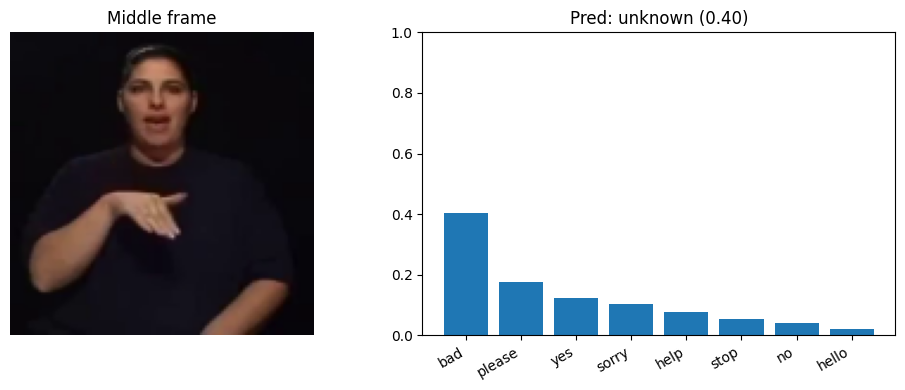

In [ ]:
import matplotlib.pyplot as plt

def visualize_clip_with_probs(frames_rgb_01, probs_dict, title=""):
    # Show middle frame with landmarks
    t = frames_rgb_01.shape[0]//2
    img = (frames_rgb_01[t]*255).astype(np.uint8)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title("Middle frame")
    # Prob bars
    names = list(probs_dict.keys()); vals = [probs_dict[k] for k in names]
    order = np.argsort(vals)[::-1][:8]
    plt.subplot(1,2,2); plt.bar([names[i] for i in order], [vals[i] for i in order])
    plt.xticks(rotation=30, ha='right'); plt.ylim(0,1); plt.title(title)
    plt.tight_layout(); plt.show()

lab, conf, probs = classify_clip_skeleton_final(clip)
visualize_clip_with_probs(clip, probs, title=f"Pred: {lab} ({conf:.2f})")


# Cell G1 — Compare with/without agreement on TEST

In [ ]:
# Compare acceptance/accuracy with and without the agreement filter
r_agree    = eval_batch(Xte_keep, yte_keep, pthr=BEST_THR, margin=BEST_MARGIN, use_agreement=True)
r_no_agree = eval_batch(Xte_keep, yte_keep, pthr=BEST_THR, margin=BEST_MARGIN, use_agreement=False)
print("With agreement   :", r_agree)
print("Without agreement:", r_no_agree)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/sy

With agreement   : {'overall_acc': 0.625, 'accepted': 7, 'total': 8, 'acc_among_accepted': 0.7142857142857143, 'abstain_rate': 0.125}
Without agreement: {'overall_acc': 0.75, 'accepted': 8, 'total': 8, 'acc_among_accepted': 0.75, 'abstain_rate': 0.0}


# Cell G2 — Why a clip became “unknown” (show LR vs prototype)

In [ ]:
# Inspect a test clip: see LR top-2, prototype top-1, and the final decision path
def inspect_test(idx):
    clip = Xte_keep[idx]
    true_id = yte_keep[idx]
    true_word = WORDS_SUB[true_id]

    # features
    seq  = extract_seq_hands(clip)
    feat = clip_features_from_sequence(seq)
    feat = feat / (np.linalg.norm(feat) + 1e-9)

    # LogReg probabilities
    proba = lr_sub.predict_proba(feat[None, :])[0]
    order = np.argsort(proba)[::-1]
    lr1, lr2 = order[0], order[1]
    print(f"TRUE: {true_word}")
    print(f"LR top1: {WORDS_SUB[lr1]}  p={proba[lr1]:.3f}")
    print(f"LR top2: {WORDS_SUB[lr2]}  p={proba[lr2]:.3f}")

    # Prototype prediction (cosine)
    proto_idx = int(np.argmax(feat[None,:] @ P.T))
    cos_sim   = float(feat @ P[proto_idx])
    print(f"PROTO : {WORDS_SUB[proto_idx]}  cos={cos_sim:.3f}")

    # Final decision (using current config)
    lab, conf, _ = classify_clip_skeleton_final(clip)
    print(f"FINAL : {lab}  conf={conf:.3f}  (thr={BEST_THR:.2f}, margin={BEST_MARGIN:.2f}, agreement={USE_AGREE})")

# Example: look at the first mis/unknown sample
for i in range(len(Xte_keep)):
    lab, conf, _ = classify_clip_skeleton_final(Xte_keep[i])
    if lab == "unknown":
        inspect_test(i)
        break


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


TRUE: bad
LR top1: bad  p=0.404
LR top2: please  p=0.176
PROTO : please  cos=0.619


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FINAL : unknown  conf=0.404  (thr=0.30, margin=0.00, agreement=True)


# Cell G3 — Optional: slightly relax for more coverage (demo knob)

In [ ]:
# Lightly relax acceptance to reduce 'unknown' in live demo
NEW_THR    = max(0.0, BEST_THR - 0.05)   # e.g., 0.25
NEW_MARGIN = max(0.0, BEST_MARGIN - 0.00)  # keep 0.00
NEW_AGREE  = False  # try disabling agreement if precision stays OK

r_relaxed = eval_batch(Xte_keep, yte_keep, pthr=NEW_THR, margin=NEW_MARGIN, use_agreement=NEW_AGREE)
print("Relaxed config:", {"thr": NEW_THR, "margin": NEW_MARGIN, "agree": NEW_AGREE})
print("TEST metrics  :", r_relaxed)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/sy

Relaxed config: {'thr': 0.25, 'margin': 0.0, 'agree': False}
TEST metrics  : {'overall_acc': 0.75, 'accepted': 8, 'total': 8, 'acc_among_accepted': 0.75, 'abstain_rate': 0.0}


# BUP-0 — Mount Drive + make safe symlinks (so writes go straight to Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, time
BASE = "/content/drive/MyDrive/speakez"         # single home on Drive
os.makedirs(BASE, exist_ok=True)

# Canonical Drive folders
DRV_SPLITS_LET  = f"{BASE}/data/splits"
DRV_SPLITS_WORD = f"{BASE}/data/word_splits"
DRV_ART_LET     = f"{BASE}/artifacts_letters"
DRV_ART_WORD    = f"{BASE}/artifacts_words"
DRV_SUBMISSIONS = f"{BASE}/submissions"
for p in [DRV_SPLITS_LET, DRV_SPLITS_WORD, DRV_ART_LET, DRV_ART_WORD, DRV_SUBMISSIONS]:
    os.makedirs(p, exist_ok=True)

# Point your usual /content paths *into* Drive via symlinks
!rm -rf /content/data; mkdir -p /content/data
!ln -sfn "$DRV_SPLITS_LET"  /content/data/splits
!ln -sfn "$DRV_SPLITS_WORD" /content/data/word_splits

!ln -sfn "$DRV_ART_LET"     /content/speakez_artifacts
!ln -sfn "$DRV_ART_WORD"    /content/speakez_word_artifacts

print("Letters splits  ->", os.path.realpath("/content/data/splits"))
print("Words splits    ->", os.path.realpath("/content/data/word_splits"))
print("Letters models  ->", os.path.realpath("/content/speakez_artifacts"))
print("Words models    ->", os.path.realpath("/content/speakez_word_artifacts"))


Mounted at /content/drive
Letters splits  -> /content/drive/MyDrive/speakez/data/splits
Words splits    -> /content/drive/MyDrive/speakez/data/word_splits
Letters models  -> /content/drive/MyDrive/speakez/artifacts_letters
Words models    -> /content/speakez_word_artifacts


BUP-1 — Keras “always to Drive” callbacks (history + best checkpoint + resume)

Use these for letters training (or any Keras model). They save directly to Drive and also create a resumable backup.

In [ ]:
import tensorflow as tf, os, json

def make_callbacks(out_dir, model_stub, monitor="val_accuracy"):
    os.makedirs(out_dir, exist_ok=True)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(out_dir, f"{model_stub}.keras"),  # native Keras format
        monitor=monitor, save_best_only=True, verbose=1
    )
    csv = tf.keras.callbacks.CSVLogger(os.path.join(out_dir, f"{model_stub}_history.csv"), append=False)
    bk  = tf.keras.callbacks.BackupAndRestore(backup_dir=os.path.join(out_dir, f"_resume/{model_stub}"))
    lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    es  = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=7, restore_best_weights=True, verbose=1)
    return [ckpt, csv, bk, lr, es]

# Example (letters):
LETTERS_OUT = "/content/speakez_artifacts"  # points to Drive via symlink
letters_callbacks = make_callbacks(LETTERS_OUT, "best_asl_baseline_128")
print("Callbacks ready:", [type(c).__name__ for c in letters_callbacks])


Callbacks ready: ['ModelCheckpoint', 'CSVLogger', 'BackupAndRestore', 'ReduceLROnPlateau', 'EarlyStopping']


BUP-1 — Keras “always to Drive” callbacks (history + best checkpoint + resume)

In [ ]:
import tensorflow as tf, os, json

def make_callbacks(out_dir, model_stub, monitor="val_accuracy"):
    os.makedirs(out_dir, exist_ok=True)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(out_dir, f"{model_stub}.keras"),  # native Keras format
        monitor=monitor, save_best_only=True, verbose=1
    )
    csv = tf.keras.callbacks.CSVLogger(os.path.join(out_dir, f"{model_stub}_history.csv"), append=False)
    bk  = tf.keras.callbacks.BackupAndRestore(backup_dir=os.path.join(out_dir, f"_resume/{model_stub}"))
    lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    es  = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=7, restore_best_weights=True, verbose=1)
    return [ckpt, csv, bk, lr, es]

# Example (letters):
LETTERS_OUT = "/content/speakez_artifacts"  # points to Drive via symlink
letters_callbacks = make_callbacks(LETTERS_OUT, "best_asl_baseline_128")
print("Callbacks ready:", [type(c).__name__ for c in letters_callbacks])


Callbacks ready: ['ModelCheckpoint', 'CSVLogger', 'BackupAndRestore', 'ReduceLROnPlateau', 'EarlyStopping']


BUP-2 — “One-click snapshot” (datasets + artifacts → timestamped ZIP on Drive)

In [ ]:
import os, time, zipfile, glob, json
STAMP = time.strftime("%Y%m%d-%H%M")
SUBDIR = f"/content/drive/MyDrive/speakez/submissions/snapshot_{STAMP}"
os.makedirs(SUBDIR, exist_ok=True)

INCLUDE_DIRS = [
    "/content/data/splits",
    "/content/data/word_splits",
    "/content/speakez_artifacts",
    "/content/speakez_word_artifacts",
]
ZIP_PATH = os.path.join(SUBDIR, f"speakez_snapshot_{STAMP}.zip")

def add_dir(zf, root, arc_root):
    for path in glob.glob(os.path.join(root, "**"), recursive=True):
        if os.path.isdir(path): continue
        arcname = os.path.join(arc_root, os.path.relpath(path, root))
        zf.write(path, arcname)

with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for d in INCLUDE_DIRS:
        if os.path.exists(d):
            add_dir(zf, d, os.path.basename(d))
print("Snapshot at:", ZIP_PATH)


KeyboardInterrupt: 

BUP-3 — Words artifacts: always save to Drive (no Keras)

In [ ]:
# Example after you fit the LogisticRegression 'lr_sub' and choose thresholds/subset:
import joblib, json, numpy as np, os

ART = "/content/speakez_word_artifacts"  # Drive
os.makedirs(ART, exist_ok=True)

# Required artifacts to persist:
# - lr_sub (joblib), thresholds.json, words_subset.json, (optional) prototypes npz
joblib.dump(lr_sub, os.path.join(ART, "word_skel_logreg_8.joblib"))
json.dump({"prob_threshold": 0.25, "top2_margin": 0.00, "agreement": False},
          open(os.path.join(ART, "thresholds.json"), "w"), indent=2)
json.dump({"ids": list(range(len(WORDS))), "words": WORDS},
          open(os.path.join(ART, "words_subset.json"), "w"), indent=2)

# (Optional) save prototypes if you computed them
# np.savez(os.path.join(ART, "word_skel_prototypes_8.npz"), protos=P, words=np.array(WORDS, dtype=object))

print("Saved to Drive:", os.listdir(ART))


BUP-4 — Quick integrity check (shapes + files exist)

In [ ]:
import numpy as np, os, json, glob

def exists(p): return "OK" if os.path.exists(p) else "MISSING"

print("Letters splits:",
      exists("/content/data/splits/X_train.npy"),
      exists("/content/data/splits/X_val.npy"),
      exists("/content/data/splits/X_test.npy"))

print("Letters model:",
      exists("/content/speakez_artifacts/best_asl_baseline_128.keras"))

print("Words splits:",
      exists("/content/data/word_splits/X_train.npy"),
      exists("/content/data/word_splits/labels.json"))

print("Words artifacts:",
      exists("/content/speakez_word_artifacts/word_skel_logreg_8.joblib"),
      exists("/content/speakez_word_artifacts/thresholds.json"),
      exists("/content/speakez_word_artifacts/words_subset.json"))


SNAP-0 — Snapshot utilities (zip + checksums)

In [ ]:
import os, time, glob, json, hashlib, zipfile
from pathlib import Path

BASE = "/content/drive/MyDrive/speakez"
SUBM = f"{BASE}/submissions"
os.makedirs(SUBM, exist_ok=True)

# What to include by default (all are on Drive via BUP-0 symlinks)
INCLUDE_MODELS = [
    "/content/speakez_artifacts",        # letters artifacts
    "/content/speakez_word_artifacts",   # words artifacts
]
INCLUDE_SPLITS = [
    "/content/data/splits",              # letters npy splits
    "/content/data/word_splits",         # words npy splits
]

def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

def make_snapshot_zip(tag="run", include_splits=False, extra_paths=None, epoch=None):
    """
    Create a timestamped zip under Drive with (models [+ splits]).
    Returns (zip_path, checksums_path).
    """
    stamp = time.strftime("%Y%m%d-%H%M%S")
    suffix = f"{tag}_e{epoch:03d}" if epoch is not None else tag
    out_dir = Path(SUBM) / f"snapshot_{stamp}_{suffix}"
    out_dir.mkdir(parents=True, exist_ok=True)
    zip_path = out_dir / f"speakez_{suffix}.zip"

    include_dirs = list(INCLUDE_MODELS)
    if include_splits:
        include_dirs += INCLUDE_SPLITS
    if extra_paths:
        include_dirs += list(extra_paths)

    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root in include_dirs:
            if not os.path.exists(root):
                print("skip (missing):", root);
                continue
            for f in glob.glob(os.path.join(root, "**"), recursive=True):
                if os.path.isdir(f):
                    continue
                arcname = os.path.relpath(f, start="/content")
                zf.write(f, arcname)

    # checksums for integrity
    checks = {}
    for f in glob.glob(str(zip_path)):
        checks[os.path.basename(f)] = {"sha256": _sha256(f), "bytes": os.path.getsize(f)}
    checks_path = out_dir / "CHECKSUMS.json"
    with open(checks_path, "w") as fp:
        json.dump(checks, fp, indent=2)

    print("Snapshot created:", zip_path)
    print("Checksums:", checks_path)
    return str(zip_path), str(checks_path)


SNAP-1 — Keras callback to snapshot every N epochs (and at the end)

In [ ]:
import tensorflow as tf

class SnapshotZipCallback(tf.keras.callbacks.Callback):
    def __init__(self, every=5, include_splits="first", tag="letters"):
        """
        every: snapshot cadence in epochs (e.g., 5)
        include_splits: False | True | "first"
        tag: label in filenames (e.g., 'letters' or 'words')
        """
        super().__init__()
        self.every = max(1, int(every))
        self.include_splits = include_splits
        self.tag = tag
        self._did_full = False

    def _do_snapshot(self, epoch=None, force_full=False):
        include = False
        if self.include_splits is True or force_full:
            include = True
        elif self.include_splits == "first" and not self._did_full:
            include = True
            self._did_full = True
        make_snapshot_zip(tag=self.tag, include_splits=include, epoch=(epoch if epoch is not None else None))

    def on_epoch_end(self, epoch, logs=None):
        # 1-based display
        if ((epoch + 1) % self.every) == 0:
            self._do_snapshot(epoch=(epoch+1))

    def on_train_end(self, logs=None):
        # Always snapshot at the end; don't repeat huge splits unless asked
        self._do_snapshot(epoch=None, force_full=False)
        print("[SnapshotZipCallback] Final snapshot complete.")


SNAP-2 — One-shot snapshot after words artifacts are saved

In [ ]:
# After you run your words pipeline and save artifacts to /content/speakez_word_artifacts:
make_snapshot_zip(tag="words", include_splits=True)


SNAP-3 — Manual “NOW” snapshot button (handy anywhere)

In [ ]:
# Call this anytime you want an immediate full snapshot during a session:
_ = make_snapshot_zip(tag="manual", include_splits=True)


Plan for the UI we only need these artefacts:

Must-have (load at runtime)

Letters (A–Z + SPACE/DEL/NOTHING)

/content/speakez_artifacts/best_asl_baseline_128.h5
(or the same model saved as best_asl_baseline_128.keras; either is fine in the UI code)

Words (8-class skeleton LogReg)

/content/speakez_word_artifacts/word_skel_logreg_8.joblib

/content/speakez_word_artifacts/thresholds.json (use: prob_threshold=0.25, top2_margin=0.00, agreement=false)

/content/speakez_word_artifacts/words_subset.json (contains the 8 words: ["yes","no","please","stop","bad","sorry","help","hello"])

Nice-to-have (only if you want the “agreement” rule)

/content/speakez_word_artifacts/word_skel_prototypes_8.npz

You do not need the experimental clip encoders (best_word_mnet_tavg*.h5) for the UI we built. 👍

In [ ]:
#Quick verify cell (run in Colab)
import os, json

must = [
  "/content/speakez_artifacts/best_asl_baseline_128.h5",
  "/content/speakez_word_artifacts/word_skel_logreg_8.joblib",
  "/content/speakez_word_artifacts/thresholds.json",
  "/content/speakez_word_artifacts/words_subset.json",
]
nice = ["/content/speakez_word_artifacts/word_skel_prototypes_8.npz"]

def stat(p):
    return ("OK", os.path.getsize(p)) if os.path.exists(p) else ("MISSING", 0)

print("== MUST-HAVE ==")
for p in must:
    s, sz = stat(p); print(f"{s:8} {sz:10,d}  {p}")

print("\n== NICE-TO-HAVE ==")
for p in nice:
    s, sz = stat(p); print(f"{s:8} {sz:10,d}  {p}")

# Optional: show thresholds + words loaded
try:
    thr = json.load(open("/content/speakez_word_artifacts/thresholds.json"))
    words = json.load(open("/content/speakez_word_artifacts/words_subset.json"))["words"]
    print("\nConfig:", thr, "\nWords subset:", words)
except Exception as e:
    print("\nConfig check skipped:", e)


== MUST-HAVE ==
MISSING           0  /content/speakez_artifacts/best_asl_baseline_128.h5
OK           11,863  /content/speakez_word_artifacts/word_skel_logreg_8.joblib
OK               70  /content/speakez_word_artifacts/thresholds.json
OK              186  /content/speakez_word_artifacts/words_subset.json

== NICE-TO-HAVE ==
OK            6,140  /content/speakez_word_artifacts/word_skel_prototypes_8.npz

Config: {'prob_threshold': 0.3, 'top2_margin': 0.0, 'agreement': True} 
Words subset: ['yes', 'no', 'please', 'stop', 'bad', 'sorry', 'help', 'hello']


One-click “rescue” (zip the exact files to Drive)

In [ ]:
import os, time, zipfile, pathlib
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

OUT_DIR = "/content/drive/MyDrive/speakez/submissions"
os.makedirs(OUT_DIR, exist_ok=True)
stamp = time.strftime("%Y%m%d-%H%M%S")
zip_path = f"{OUT_DIR}/speakez_UI_models_{stamp}.zip"

files = [
  "/content/speakez_artifacts/best_asl_baseline_128.h5",
  "/content/speakez_word_artifacts/word_skel_logreg_8.joblib",
  "/content/speakez_word_artifacts/thresholds.json",
  "/content/speakez_word_artifacts/words_subset.json",
  "/content/speakez_word_artifacts/word_skel_prototypes_8.npz", # ok if missing
]

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in files:
        if os.path.exists(f):
            zf.write(f, arcname=os.path.relpath(f, "/content"))
        else:
            print("SKIP (missing):", f)

print("Rescued zip:", zip_path)


Mounted at /content/drive
SKIP (missing): /content/speakez_artifacts/best_asl_baseline_128.h5
Rescued zip: /content/drive/MyDrive/speakez/submissions/speakez_UI_models_20251006-055007.zip
